# Некоторые приемы предсказания ВР

При построении моделей прогноза полезным использование таких приемов, как:
* Оконное тестирование данных [(обратное тестирование)](https://joaquinamatrodrigo.github.io/skforecast/0.11.0/introduction-forecasting/introduction-forecasting.html#backtesting-forecasting-models).
* Использование дополнительных метрик [оценки качества прогноза](https://www.lokad.com/forecasting-accuracy-definition/), в том числе [вероятностное прогнозирование](https://www.sktime.net/en/latest/examples/01b_forecasting_proba.html)
* Построение прогнозов с использованием сторонних библиотек (в первую очередь [`sklearn`](https://www.aeon-toolkit.org/en/latest/examples/forecasting/forecasting_sklearn.html))
* Построение конвейеров прогноза и автоматический выбор ступеней конвейера, их параметров и вариантов ([`auto ml`](https://arxiv.org/abs/2312.08528))
* [Ансамблирование прогнозов](https://habr.com/ru/articles/571296/).

В целом отметим [общий фреймворк](https://unit8.com/resources/darts-time-series-made-easy-in-python/), который можно бы было рекомендовать при проектироании экспериментов по предсказанию ВР одолженную в пакете [`darts`](https://github.com/unit8co/darts):
<img src="https://unit8.com/wp-content/uploads/2021/07/1_yaHh5V0AgxEYxJYrv9VQmA.png"
      style="width: 650px">

## Импорт и набор данных


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
    import sktime
except:
    !pip3 install sktime --user
    !pip3 install pmdarima
    !pip3 install statsmodels
    !pip3 install prophet
import sktime

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
# import pmdarima as pm

In [4]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=NotImplementedError)
warnings.simplefilter('ignore', category=UserWarning)

In [5]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sktime.utils.plotting import plot_series
from sktime.utils.plotting import plot_windows
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection  import ExpandingWindowSplitter
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError

smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

from sktime.transformations.series.difference import Differencer

Импорт данных аналогично предыдущего урока.

Check splitted data size: Train: 118, Test: 143


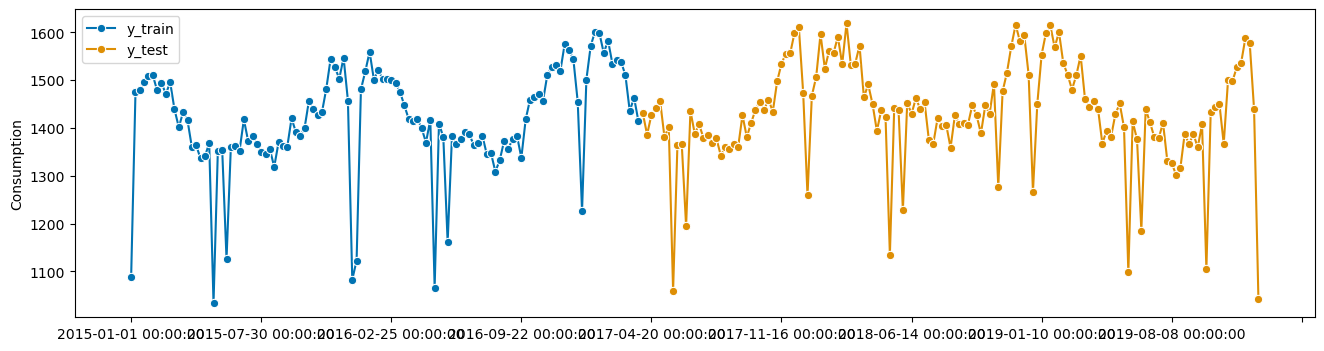

In [6]:
path_ts = 'de_data.csv'
df = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")
y  = df.Consumption.asfreq('7d')

TEST_SIZE = int(0.55*y.size)
y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)
print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

## Обратное и последовательное тестирование моделей

Самый простой способ оценить производительность модели машинного обучения - разделить набор данных на два подмножества: обучающий и тестовый наборы. Для дальнейшего повышения надежности  оценки производительности мы можем  разделить  набор данных несколько раз по аналогии с методом `k-folds`. Однако, в соответствии с особенностями временных рядов - временной связанностью метод`k-folds` должен [не нарушать принцип казуальности](https://forecastegy.com/posts/time-series-cross-validation-python/). Другими словами [выборка валидации должна следовать за тренировочными данными](https://otexts.com/fpp3/tscv.html). Проще всего организовать такое следование в рамках имеющейся тренировочной выборки. Другими словами модель испытывается на исторических (ретро) данных. Такой подход также известен как [<tt>backtesting</tt>](https://joaquinamatrodrigo.github.io/skforecast/0.8.1/user_guides/backtesting.html).

>Напомним, результат [кросс-валидации](https://www.statology.org/k-fold-cross-validation/) по нескольким блокам более валиден [(менее смещен)](https://machinelearningmastery.com/k-fold-cross-validation/), нежели валидация одной [отложенной выборкой](https://scikit-learn.org/stable/modules/cross_validation.html).



### Обнавление предсказаний в процессе работы

Перед рассмотрением оконного преобразования отметим возможность использования обнавления предсказаний по результатам накопления данных. 

Допустим, что у нас есть лишь часть наших тестовых данных, размеро в 1 год. Это будет наш 1й тестовый набор. Вторую же часть мы получим позже (на второй год) - это будет наш второй тестовых набор. Часть методов предсказания позволяют проводить обновление результатов для подобных случаев. 

Отметим важность следующего фактора. Для ряда методов допустимо именно обновление моделей предсказаний, тогда  для остальных методов может иметь место лишь переобучение модели. Также важно отметить, что качество работы обновленной и переобученной моделей может различаться.

Теперь давайте поробуем промоделировать ситуацию обновления предсказателей с периодом 1 год.

<!-- Some forecasters need the forecasting horizon to be provided in fit. Such forecasters will produce informative error messages when it is not passed in fit. All forecaster will remember the horizon when passed in fit for prediction. An example -->

Check splitted data size: Train: 105, Test: 156


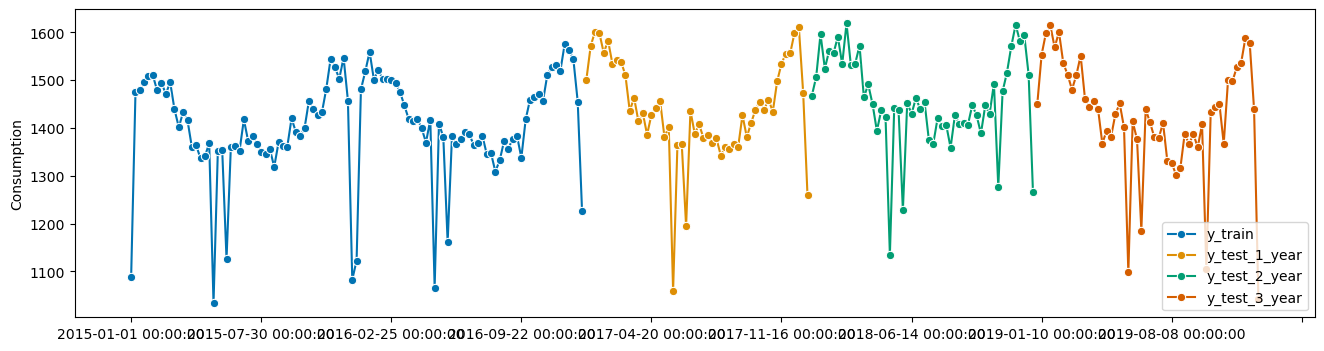

In [14]:
TEST_SIZE = int(0.6*y.size)

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)
# 
y_test_1, y_test_2, y_test_3 = y_test.iloc[:52], y_test.iloc[52:104], y_test.iloc[104:]

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

plot_series(y_train, y_test_1, y_test_2, y_test_3, 
                                  labels=["y_train", "y_test_1_year", "y_test_2_year", "y_test_3_year"]);


начнем с обучения на тренировочной выборке

sMAPE = 0.037


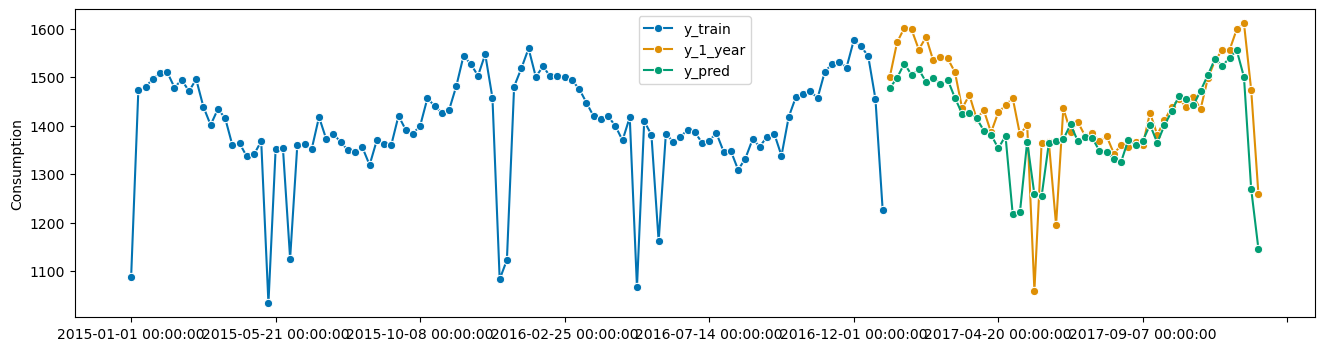

In [15]:
forecaster =  NaiveForecaster(strategy='mean', sp=52)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test_1.index, is_relative=False)
y_pred = forecaster.predict(fh=fh)

plot_series(y_train, y_test_1, y_pred, labels=["y_train", "y_1_year", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test_1.values):.3f}')

Теперь обновим  модель предсказания при помощи метода `update`.  Отметим, что обновление могут быть произведены только с точки зрения накопления данных, если в методе  задать `update_params=False`. Также метод может быть использован в случае деления выборки на последовательные (во времени) батчи. Кроме того важно указать, что не все методы предсказания имеют реализованный метод `update`. Надеемся в будущем эта ошибка будет исправлена

<!-- The update interface provides an option for this, via the update_params argument of update and other update funtions.

If update_params is set to False, no model update computations are performed; only data is stored, and the internal “now” state (the cutoff) is set to the most recent date. -->

sMAPE = 0.044


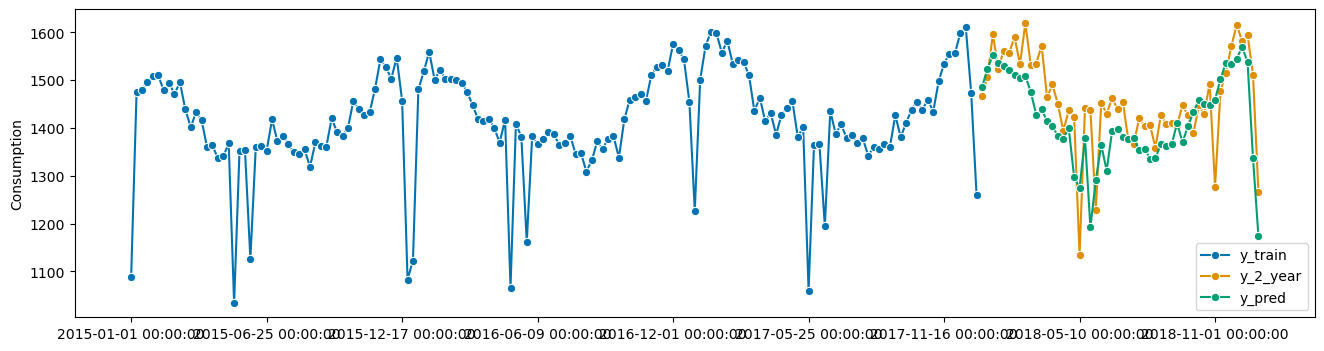

In [16]:
forecaster.update(y_test_1)

fh = ForecastingHorizon(y_test_2.index, is_relative=False)

y_pred = forecaster.predict(fh=fh)

plot_series(pd.concat([y_train, y_test_1]), y_test_2, y_pred, labels=["y_train", "y_2_year", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test_2.values):.3f}')

 и т.д. Отметим что предсказание и обновление могут быть объеденены в методе `update_predict_single`

sMAPE = 0.037


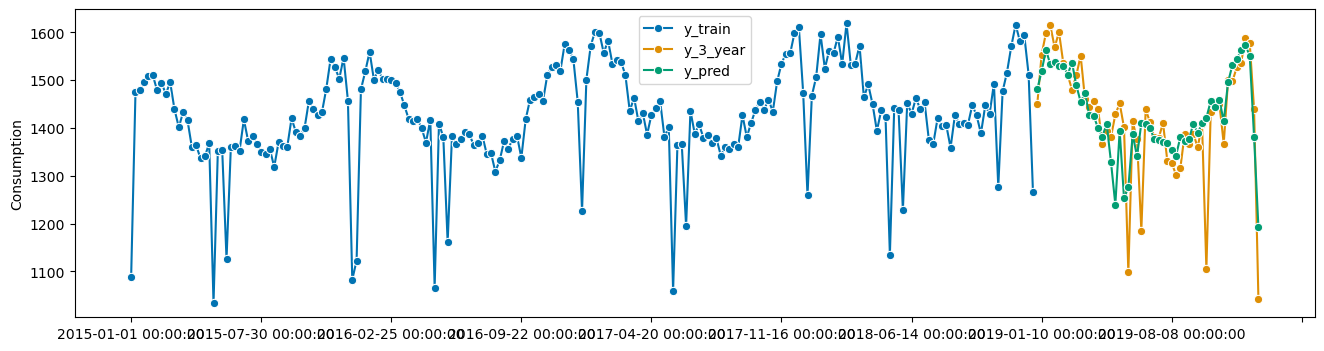

In [17]:
forecaster.update(y_test_2)

fh = ForecastingHorizon(y_test_3.index, is_relative=False)

y_pred = forecaster.predict(fh=fh)

plot_series(pd.concat([y_train, y_test_1, y_test_2]), y_test_3, y_pred, labels=["y_train", "y_3_year", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test_3.values):.3f}')

### Оконное тестирование данных

В случае временного ряда кросс валидация может быть выполнена в скользящем окне по данным  [<tt>rolling backtest evaluation</tt>](https://docs.aws.amazon.com/whitepapers/latest/time-series-forecasting-principles-with-amazon-forecast/step-4-evaluate-predictors.html#prediction-quantiles-and-accuracy-metrics).
> [Приемущественно метода](https://mydata.ch/backtesting-in-time-series-forecasting-for-maximum-performance/)  бектеста скользящим окном следующие:
>* позволяет  быть уверенным, что  прогнозы точны и последовательны в течение длительного периода времени.
>* может помочь  найти и исправить "плавоющие" ошибки в модели данных. То есть редкие, но достаточно регулярные ошибки (неучтенную информоацию), которые можно участь в модели.
>* может помочь выявить недостающие внешние факторы в данных, которые помогут модели делать более точные прогнозы.
<!-- ✅It allows you to ensure that your forecasts are accurate and consistent over a long period of time

✅It can help you to find and correct errors in your models.

✅It can help you to identify missing external factors in your data that would help the model make better forecasts -->

>Напомним, что в прогнозировании временных рядов под бэктестингом понимается процесс проверки модели прогноза на исторических данных. Этот метод предполагает пошаговое движение назад во времени, чтобы оценить, насколько хорошо показала бы себя модель, если бы она использовалась для прогнозирования в этот период времени.

С технической точки зрения идея тут [заключается следующем](https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/backtesting.html). Задается некторая ширина окна временного ряда. Заданное окно скользит по временному ряду с начального положения, например, таким образом, что все данные перед ним являются тренировочными, а после тестовыми. Могут быть и [другие стратегии](https://www.sktime.net/en/stable/examples/forecasting/window_splitters.html), например, что только лишь выборка заданного размера перед окном является тренировочной. Такие стратегии называются `ExpandingWindowSplitter` и `SlidingWindowSplitter` соответственно.

Для использования данных стратегий рекомендуем задавать оконо списком чисел вместо дат. Попробуем для начала визуализировать `ExpandingWindowSplitter`

> Отметим что по своей идеалогии данная процедура аналогична тому, что модель бы тестировалась на поступающих данных в соответствующих рабочих режмах. При этом целью такого тестирования бы была оценка работоспособности модели. Другими словами тестирование гипотезы о необходимости сменить модель (например переобучить). Такая процедура называется [<tt>walk-forward validation</tt>](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/).

<!-- In time series forecasting, backtesting refers to the process of validating a predictive model using historical data. The technique involves moving backwards in time, step-by-step, to assess how well a model would have performed if it had been used to make predictions during that time period. -->

Number of Folds = 11


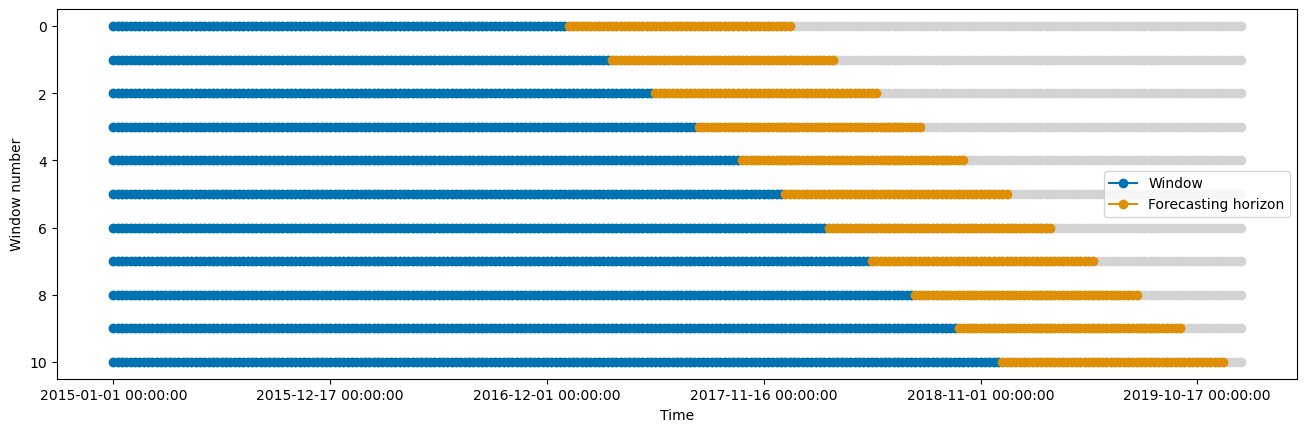

In [18]:
fh=1+np.arange(52)
cv = ExpandingWindowSplitter(step_length=10, fh=fh,  initial_window = len(y_train) )
plot_windows(cv, y)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Отметим, что в целом стратегии спилата окон [могут быть и другими]( https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/backtesting.html).


Провести [валидацию модели](https://www.sktime.net/en/latest/examples/01_forecasting.html) на можно при помощи метода [`evaluate`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.model_evaluation.evaluate.html). Обратите внимание тут в качестве входных данных мы используем только значения временного ряда, без указания их временного шага. Отметим, что в некоторых моделя это будет не корректно. В данном случае в качестве аргумента `cv` мы зададим сплитер, визуализированный выше. Также выбирем стратегию оценки `refit`. То есть каждый раз модель будет полностью переобучаться. Возможны также стратегии `update` и `no-update_params`.

In [11]:
df = evaluate(forecaster=forecaster, y=y.values, cv=cv, strategy="refit", return_data=True)
df.iloc[:, :5].head(5)

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.036514,0.004278,0.005107,105,104
1,0.034604,0.002939,0.005481,115,114
2,0.036885,0.004787,0.005276,125,124
3,0.037412,0.003548,0.005096,135,134
4,0.041095,0.005128,0.004016,145,144


Из таблицы виден небольшой рост ошибки с увеличением шага валидации. Рекомендуется оценивать статистические характеристики прогноза перед его развертыванием в рабочем режиме. Также как и рекомендуется регулярно переоценивать характеристики в процессе работы. Для этого оценка может быть проведена по выбранным метрикам и с заданным периодом. Метрика может быть задана аргументом `scoring`.  В примере ниже мы проведем такую оценку без повторного обучения модели. В качестве метрики зададим `MeanSquaredPercentageError`.

In [12]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanSquaredPercentageError

df = evaluate(forecaster=forecaster, y=y.values, cv=cv, 
              strategy="no-update_params", return_data=True, 
              scoring=MeanSquaredPercentageError() )

df.iloc[:, :5].head(5)

,test_MeanSquaredPercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.003181,0.005091,0.006073,105,104
1,0.002979,0.003866,0.009250,115,114
2,0.003647,0.002785,0.003160,125,124
3,0.004029,0.003205,0.005792,135,134
4,0.004239,0.003560,0.006121,145,144


Отметим, что оценка может быть проведена по нескольким метрикам!

In [13]:
from sktime.performance_metrics.forecasting import MeanSquaredError

smape_loss = MeanAbsolutePercentageError(symmetric=True)
rmse       = MeanSquaredError(square_root=True)

forecaster = forecaster.clone()
scorers = [smape_loss, rmse]
df = evaluate(forecaster, y=y, cv=cv, scoring=scorers, return_data=True)
df.iloc[:, :5].head(5)

,test_MeanAbsolutePercentageError,test_MeanSquaredError,fit_time,pred_time,len_train_window
0,0.037104,76.009946,0.003760,0.009545,105
1,0.035137,74.463990,0.003267,0.009140,115
2,0.037084,72.834035,0.002340,0.009057,125
3,0.038476,74.699395,0.002813,0.004841,135
4,0.042243,77.284179,0.003411,0.005958,145


Процедура <tt>backtest</tt> важна при несмещенной оценке показателей модели. ТО есть при выборе лучших моделей для решения тех или иных задач. В этом смысле процедура сравнима (но не эквивалентна!) процедуре [`bagging`](https://otexts.com/fpp3/bootstrap.html).

Отметим также, что при помощи процедуры `backtest` может быть построена процедура автоматизированногог сравнения моделей предсказания [`benchmarking`](https://github.com/sktime/sktime/blob/main/examples/04_benchmarking_v2.ipynb).

В некоторых случаях также полезным может быть визуализация результатов оценки `evaluate`. Она может быть проведена следующим образом.

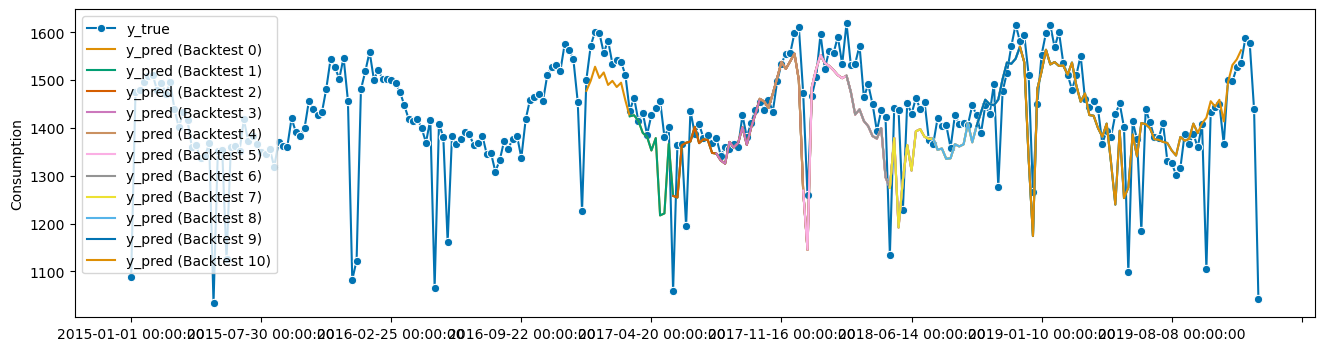

In [14]:
cv_len = len(df["y_pred"])

plot_series(
    y,
    *[df["y_pred"].iloc[i] for i in range(cv_len)],
     markers=["o"]+[""]*cv_len,
     labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(cv_len)],
);

## Вероятностные предсказания

### Особенности вероятностного прогнозирования

Типичные реализации прогнозирования, которые мы рассматривали прежде [являются точечными](https://www.lokad.com/probabilistic-forecasting-definition/). То есть предсказывают одно значение для одного шага прогноза. Такое поведение модели явялется нормальным. Однако,  в ряде случаев помимо самого значения прогноза требуется знание каких то [статистческих характеристик прогноза](https://otexts.com/fpp3/prediction-intervals.html). В наиболее полном случае требуется знание распределения результатов прогноза для каждой точки. Такой прогноз [называется  вероятностным](https://www.lokad.com/tv/2022/3/2/probabilistic-forecasting-for-supply-chain/). 

Другими словами вероятностный прогноз содержит набор вероятностей, связанных со всеми возможными будущими исходами для каждой точки прогноза. В противовес этому точечный прогноз указывает на один конкретный исход в качестве "прогноза". 

Вероятностные прогнозы важны, когда неопределенность прогназирования значема и неустранима Факторы неопределнности прогноза почти всегда имеет место в сложных системах. Например, для цепочек поставок вероятностные прогнозы необходимы для принятия надежных решений в условиях неопределенности будущего. В частности, спрос и время выполнения заказа - два ключевых аспекта анализа цепочки поставок - лучше всего учитывать с помощью вероятностного прогнозирования. Вероятностная перспектива естественным образом способствует экономической приоритезации решений на основе их ожидаемой, но неопределенной отдачи. 

Важно отметить, что не все методы прогноза допускают вероятностное прогназирование. Более того для оценки точности вероятностного прогноза требуются специальные метрики, которые отличаются от детерминированных аналогов. А также для использования вероятностных прогнозов требуется специализированный инструментарий, отличающийся от детерминированных аналогов.

<!-- A forecast is said to be probabilistic, instead of deterministic, if it contains a set of probabilities associated with all possible future outcomes, instead of pinpointing one particular outcome as “the” forecast. Probabilistic forecasts are important whenever uncertainty is irreducible, which is nearly always the case whenever complex systems are concerned. For supply chains, probabilistic forecasts are essential to produce robust decisions against uncertain future conditions. In particular, demand and lead time, two key aspects of the supply chain analysis, are both best addressed via probabilistic forecasting. The probabilistic perspective lends itself naturally to the economic prioritization of the decisions based on their expected but uncertain returns. A large variety of statistical models deliver probabilistic forecasts. Some are structurally close to their deterministic counterparts while others are very different. Assessing the accuracy of a probabilistic forecast requires specific metrics, which differ from their deterministic counterparts. The exploitation of probabilistic forecasts requires specialized tooling that diverges from its deterministic counterparts. -->

И так, [Вероятностное прогнозирование обобщает](https://www.lokad.com/probabilistic-forecasting-definition/) то, что известно о будущих событиях, или мнения о них. В отличие от прогнозов с одним значением (point forecast) (например, прогнозов о том, что максимальная температура в данном месте в данный день составит 23 градуса Цельсия или что результатом данного футбольного матча будет безголевая ничья), вероятностные прогнозы присваивают вероятность каждому из нескольких различных исходов, а полный набор вероятностей представляет собой вероятностный прогноз (Probabilistic Forecasting). Другими словами в таким прогнозе мы предсказываем интервал значений, ассоциирующийся с неопределенностью предсказания (prediction intervals, Интервал прогнозирования - это диапазон значений, которые прогноз может принимать с заданной вероятностью. ). 
<!-- Probabilistic forecasting summarizes what is known about, or opinions about, future events. In contrast to single-valued forecasts (such as forecasting that the maximum temperature at a given site on a given day will be 23 degrees Celsius, or that the result in a given football match will be a no-score draw), probabilistic forecasts assign a probability to each of a number of different outcomes, and the complete set of probabilities represents a probability forecast. In other words, in such a prediction, we predict an interval of values associated with the prediction uncertainty 

 A prediction interval is a range of values that the forecast can take with a given probability.


В общем случае Результаты вероятностного прогнозирования [могут быть](https://www.sktime.net/en/latest/examples/01b_forecasting_proba.html): 
* интервалы - `predict_interval(fh=None, X=None, coverage=0.90)`
* квантили - `predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])`
* диспрсия - `predict_var(fh=None, X=None, cov=False)`
* распределение - `predict_proba(fh=None, X=None, marginal=True)`

Примечания:
* у разных прогнозистов разные возможности! Также метрики, оценка и настройка различаются по "типу прогноза".
* Вероятностный прогноз может меняться от типасоставных шагов Пример: бутстрап

Заметим, $95\%$-ный интервал прогноза должен содержать диапазон значений, включающий фактическое будущее значение с вероятностью $95\%$. Тогда Вероятностное прогнозирование нацелено на получение полного прогнозного распределения. Точечное прогнозирование, с другой стороны, обычно возвращает среднее значение, медиану или другую точечную меру указанного распределения. Однако в реальных сценариях лучше прогнозировать не только наиболее вероятный будущий результат, но и множество альтернативных исходов.

<!-- 
In other words You can always train a forecasting model on historical data and predict a certain value, but this will never be more than a (hopefully) reasonable estimate. 

What is probabilistic forecasting? Intuition
* produce low/high scenarios of forecasts
* quantify uncertainty around forecasts
* produce expected range of variation of forecasts

Generally, probabilistic forecasting results could be : 
* forecast intervals - predict_interval(fh=None, X=None, coverage=0.90)
* forecast quantiles - predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])
* forecast variance - predict_var(fh=None, X=None, cov=False)
* distribution forecast - predict_proba(fh=None, X=None, marginal=True)

Notes:
* different forecasters have different capabilities! 
* Also metrics, evaluation & tuning are different by “type of forecast”.

Hence, a 95% prediction interval should contain a range of values that include the actual future value with probability 95%. Probabilistic forecasting aims to generate the full forecast distribution. Point forecasting, on the other hand, usually returns the mean or the median or said distribution. However, in real-world scenarios, it is better to forecast not only the most probable future outcome, but many alternative outcomes as well.
-->

<blockquote>
Формальный вид прогноза (эндогенный, одна временная метка прогноза):
* Пусть $y(t_1), \dots, y(t_n)$ - это наблюдения в фиксированные моменты времени $t_1, \dots, t_n$.
(мы рассматриваем $y$ как $\mathbb{R}^n$-значную случайную величину).
* Пусть $y'$ - это (истинное) значение, которое будет наблюдаться в будущий момент времени $\tau$.
(мы рассматриваем $y'$ как $\mathbb{R}$-значную случайную величину)

Более формальные детали и интуиция:

* __"точечный прогноз"__ - это предсказание/оценка условного ожидания $E[y'|y]$, где $y'$ - истинный результат. Интуиция: "из множества повторений/разных попыток предсказания - результат значение средним арифметическим значением".

* __"дисперсионный прогноз"__ (`predict_var(fh=None, X=None, cov=False)`) - это предсказание/оценка условного ожидания дисперсии $Var[y'|y]$. Интуиция: "из множества повторений - это значение является средним квадратичным расстоянием от наблюдения до идеального точечного прогноза".

* __"квантильный прогноз"__(`predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])`), в точке квантиля $\alpha \in (0,1)$ - это предсказание/оценка $\alpha$-квантиля $y'|y$, т.е. $F^{-1}_{y'|y}(\alpha)$, где $F^{-1}$  это (обобщенная) обратная `CDF` = квантильная функция случайной величины $y'|y$. Интуиция: "Из множества повторений вероятность появления данного будет равна или меньше  значения $\alpha$".
 
* __"Интервальный прогноз"__ или __"интервал предсказания"__ (`predict_interval(fh=None, X=None, coverage=0.90)`) с (симметричным) охватом $c \in (0,1)$ - это пара прогноз/оценка с нижней границей $a$ и верхней границей $b$, такая, что $P(\alpha \le y' \ge b|y)=c$ и $P(y'>b|y)=P(y<a|y)=(1-c)/2$. Интуиция: "Из множества повторений результат будет содержаться в интервале $[a,b]$  с вероятностью $c$. Причем вероятность того, что будут результаты выше равна вероятности того, что  будут результаты ниже".

* __"прогноз распределения"__ или __"полный вероятностный прогноз"__ (`predict_proba(fh=None, X=None, marginal=True)`)- это предсказание/оценка распределения $y'|y$ например, "это нормальное распределение со средним 42 и дисперсией 1". Интуиция: исчерпывающее описание механизма порождения множества повторений.

<!-- Примечания:
* _нижняя/верхняя часть интервальных прогнозов_ - это квантильные прогнозы в точках квантилей $0,5 - c/2$ и $0,5 + c/2$ (при условии, что распределения прогнозов абсолютно непрерывны).
* все остальные прогнозы могут быть получены из полного вероятностного прогноза; полный вероятностный прогноз может быть получен из всех квантильных или всех интервальных прогнозов.
* не существует точной зависимости между другими типами прогнозов (точечный или дисперсионный vs квантильный)
* в частности, точечный прогноз не обязательно должен быть медианным прогнозом aka 0,5-квантильным прогнозом. Это может быть 
$\alpha$-quantile для любого $\alpha$! -->
<!-- 
Частая путаница в литературе и пакетах python: * охват 'c' vs квантиль '\alpha' * охват 'c' vs значимость 'p = 1-c' * квантиль нижней границы интервала, 'p/2', vs 'p' * интервальные прогнозы vs связанные, но существенно разные понятия: доверительный интервал для прогнозируемого среднего; байесовский апостериор или интервал доверия для прогнозируемого среднего * все прогнозы выше могут быть байесовскими, путаница: "апостериоры разные" или "должны оцениваться по-разному". -->



<!-- Formal view (endogeneous, one forecast time stamp):

Let $y(t_1), \dots, y(t_n)$ be observations at fixed time stamps $t_1, \dots, t_n$.

(we consider $y$ as an $\mathbb{R}^n$-valued random variable)

Let $y'$ be a (true) value, which will be observed at a future time stamp $\tau$.

(we consider $y'$ as an $\mathbb{R}$-valued random variable)

More formal details & intuition:
* a “point forecast” is a prediction/estimate of the conditional expectation $E[y'|y]$ where $y'$ is a true result.
. Intuition: “out of many repetitions/differnt attempts to forecast, this value is the arithmetic average of all observations”.
* a “variance forecast” ('predict_var(fh=None, X=None, cov=False)')  is a prediction/estimate of the conditional expectation $Var[y'|y]$ 
. Intuition: “out of many repetitions/worlds, this value is the average squared distance of the observation to the perfect point forecast”.
* a “quantile forecast”, at quantile point  $\alpha \in (0,1)$ is a prediction/estimate of the 
$\alpha$-quantile of $y'|y$, i.e., of $F^{-1}_{y'|y}(\alpha)$, where $F^{-1}$
 is the (generalized) inverse cdf = quantile function of the random variable $y'|y$. 
 Intuition: “out of many repetitions/worlds, a fraction of exactly 
 will have equal or smaller than this value.”
* an “interval forecast” or “predictive interval” with (symmetric) coverage $c \in (0,1)$ is a prediction/estimate pair of lower bound $a$ and upper bound 
$b$ such that $P(\alpha \le y' \ge b|y)=c$
and $P(y'>b|y)=P(y<a|y)=(1-c)/2$. Intuition: “out of many repetitions/worlds, a fraction of exactly $c$
will be contained in the interval $[a,b]$, and being above is equally likely as being below”.
* a “distribution forecast” or “full probabilistic forecast” is a prediction/estimate of the distribution of $y'|y$
, e.g., “it’s a normal distribution with mean 42 and variance 1”. Intuition: exhaustive description of the generating mechanism of many repetitions/worlds.

Notes:

* lower/upper of interval forecasts are quantile forecasts at quantile points  $0.5 - c/2$
 and $0.5 + c/2$
 (as long as forecast distributions are absolutely continuous).
* all other forecasts can be obtained from a full probabilistic forecasts; a full probabilistic forecast can be obtained from all quantile forecasts or all interval forecasts.
* there is no exact relation between the other types of forecasts (point or variance vs quantile)
* in particular, point forecast does not need to be median forecast aka 0.5-quantile forecast. Can be 
$\alpha$-quantile for any $\alpha$!

Frequent confusion in literature & python packages: * coverage 'c' vs quantile '\alpha' * coverage 'c' vs significance 'p = 1-c' * quantile of lower interval bound, 'p/2', vs 'p' * interval forecasts vs related, but substantially different concepts: confidence interval on predictive mean; Bayesian posterior or credibility interval of the predictive mean * all forecasts above can be Bayesian, confusion: “posteriors are different” or “have to be evaluted differently”

 -->



<!-- **Пусть** создается "распределение" или "диапазон" прогнозных значений,
в моменты времени, определяемые **горизонтом прогнозирования** `fh`

* заданные **прошлые данные** `y` (серия) и, возможно, экзогенные данные `X`, для `подгонки` или `прогнозирования`: `fh`, `y`, `X`.
Выходные данные из `predict_probabilistic`: некоторый объект "распределения" или "диапазона"

**Большое предостережение**: существует множество возможных способов моделирования "распределения" или "диапазона"!
Используется на практике и легко путается! (и часто, практически, путают!)
 -->
<!-- 
**Let**  produce "distribution" or "range" of forecast values,
at time stamps defined by **forecasting horizon** `fh`

* given **past data** `y` (series), and possibly exogeneous data `X`, to `fit` or `predict`: `fh`, `y`, `X`
Output, from `predict_probabilistic`: some "distribution" or "range" object

**Big caveat**: there are multiple possible ways to model "distribution" or "range"!
Used in practice and easily confused! (and often, practically, confused!) -->

Одним из важных свойств вероятностного предсказания является возможность введения [дополнительных метрик](https://www.sktime.net/en/latest/examples/01b_forecasting_proba.html#overview---theory), позволяющих корректировать прогноз.

Мы ожидаем, что прогнозируемое `y` имеет форму, отличную от истинного `y`, поэтому метрики имеют вид

`metric(y_true: series, y_pred: proba_prediction) -> float`.

где `proba_prediction` - тип конкретного "типа вероятностного предсказания".

Т.е. мы имеем следующую [таблицу](https://www.sktime.net/en/latest/examples/01b_forecasting_proba.html#Formal-view-(endogeneous,-one-forecast-time-stamp)) функции для потери/метрики $L$:

<!-- | Name                  |  prediction/estimate of                   | general form |
| ----                  | ----------------------                    | -------- |
| точечный прогноз      | условное ожидание $\mathbb{E}[y'\|y]$     | `metric(y_true, y_pred)` | 
| Прогноз дисперсии     | условной дисперсии $Var[y'\|y]$           | `metric(y_pred, y_pt, y_var)` (требует точечного прогноза)     |
| квантильный прогноз   | $\alpha\in (0,1)$;  $\alpha$- квантиль от $y'\|y$  | `metric(y_true, y_quantiles, alpha)` | 
| интервальный прогноз  |  $c\in (0,1) \ for \ [a,b] \ P(a\le y' \le b \| y) = c$    |`metric(y_true, y_interval, c)` | 
| Прогноз распределения | закона/распределения $y'\|y$                       | `metric(y_true, y_distribution)` |
 -->
 
 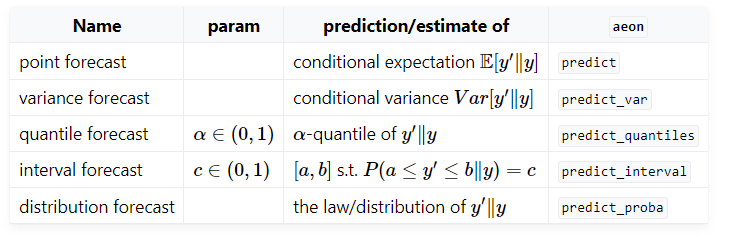
<!-- #### overview - theory

Predicted `y` has different form from true `y`, so metrics have form

`metric(y_true: series, y_pred: proba_prediction) -> float`

where `proba_prediction` is the type of the specific "probabilistic prediction type".

I.e., we have the following function signature for a loss/metric $L$:

| Name | param | prediction/estimate of | general form |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `metric(y_true, y_pred)` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `metric(y_pred, y_pt, y_var)` (requires point forecast too) |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `metric(y_true, y_quantiles, alpha)` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `metric(y_true, y_interval, c)` |
| distribution forecast | | the law/distribution of $y'\|y$ | `metric(y_true, y_distribution)` | -->


Технически существует [множество способов](https://cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html) оценки интервалов прогнозирования, большинство из которых требуют, чтобы остатки (ошибки) модели следовали [нормальному распределению](https://otexts.com/fpp3/prediction-intervals.html). Когда это свойство невозможно предположить, обычно используются несколько альтернатив: 
* Интервалы прогнозирования на основе бутстрепных остатков и [рекурсивно-многошагового прогноза](https://skforecast.org/0.5.0/user_guides/autoregresive-forecaster.html).
<img src="https://skforecast.org/0.5.0/img/diagram-recursive-mutistep-forecasting.png" alt="" style="width:500px;">
* Интервалы прогнозирования на основе квантильной регрессии и [прямого многошагового прогноза](https://skforecast.org/0.5.0/user_guides/direct-multi-step-forecasting.html).
<img src="https://skforecast.org/0.5.0/img/diagram-direct-multi-step-forecasting.png" alt="" style="width:500px;">
* Интервалы прогнозирование с использованием техники [bootstrap](https://skforecast.org/0.5.0/user_guides/prediction-intervals). При этом на каждой точке горизонта вычисляются значения нужных процентилей (квантилей).
<img src="https://skforecast.org/0.5.0/img/diagram-bootstrapping-prediction-intervals.png" style="width:500px;">
* С использованием квантильной регресии (оценка интервалов).


>[Интересно также отметить](https://robjhyndman.com/hyndsight/narrow-pi/), что  почти все интервалы прогнозирования слишком узкие. Например, номинальные 95 %-ные интервалы могут обеспечивать охват только от 71 до 87 % возможных значений прогнозов. Это хорошо известное явление, которое возникает потому, что модель распределения не учитывают все источники неопределенности. В моделях прогнозирования существует как минимум четыре источника неопределенности:
> * случайный член ошибки
> * Оценки параметров
> * Выбор модели для исторических данных
> * Продолжение процесса генерирования исторических данных в будущем.
>
> При построении интервалов прогнозирования для моделей временных рядов обычно учитывается только первый из этих источников. Поэтому целесообразно использовать тестовые данные для проверки эмпирического покрытия интервала, а не полагаться только на ожидаемое значение.

<!-- Let us note that technuically there are multiple ways to estimate prediction intervals, most of which require that the residuals (errors) of the model follow a normal distribution. When this property cannot be assumed, two alternatives commonly used are 
* Prediction intervals based on bootstrapped residuals and [recursive-multi-step forecaster](https://skforecast.org/0.5.0/user_guides/autoregresive-forecaster.html).
* Prediction intervals based on quantile regression and [direct-multi-step forecaster](https://skforecast.org/0.5.0/user_guides/direct-multi-step-forecasting.html). https://cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html

Interesting to note that 
in real-world problems, almost all prediction intervals are too narrow. For example, nominal 95% intervals may only provide coverage between 71% and 87%. This is a well-known phenomenon and arises because they do not account for all sources of uncertainty. With forecasting models, there are at least four sources of uncertainty:
The random error term
The parameter estimates
The choice of model for the historical data
The continuation of the historical data generating process into the future
When producing prediction intervals for time series models, generally only the first of these sources is taken into account. Therefore, it is advisable to use test data to validate the empirical coverage of the interval and not only rely on the expected one.
https://robjhyndman.com/hyndsight/narrow-pi/-->

<!-- https://skforecast.org/0.5.0/user_guides/prediction-intervals -->

<!-- More formally, a prediction interval defines the interval within which the true value of the response variable is expected to be found with a given probability. -->

### Примеры использования вероятностного прогноза 

Как уже было замечено вероятностное прогназирование часто используется для двух процедур:
* [процедура `backtest`](https://joaquinamatrodrigo.github.io/skforecast/0.8.1/user_guides/backtesting.html) в качестве допонительной меры отбора моделей и настройки их параметров.
* [допонительные метрики](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html) оценки для будущих значений при настройки моделей. В том числе как мера оценки [интервала разброса значений оценки](https://otexts.com/fpp3/prediction-intervals.html).

**Давайте посмотрим примеры.**



sMAPE = 0.043


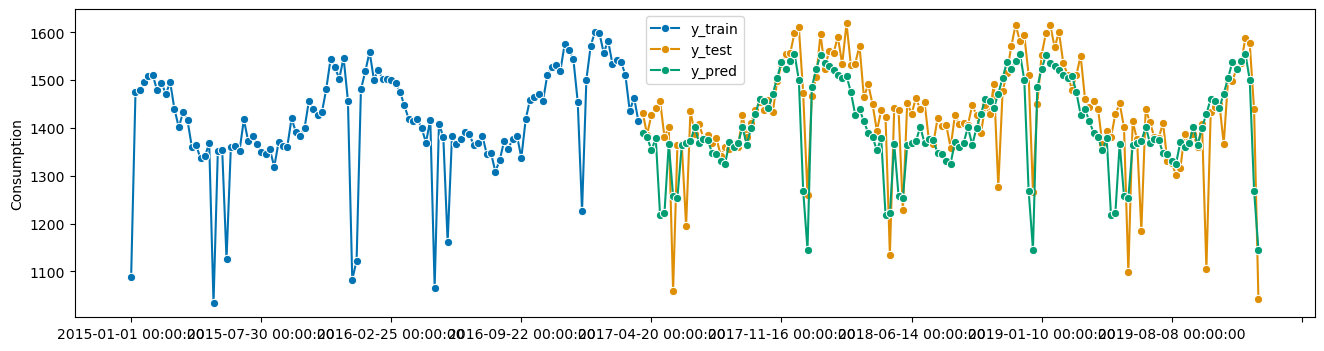

In [15]:
path_ts = 'de_data.csv'
df = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")
y = df.Consumption.asfreq('7d')
TEST_SIZE = int(0.55*y.size)
y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

forecaster =  NaiveForecaster(strategy="mean",sp=52)
forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh=fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Для начала рассмотрим случай наивного предсказания интервала покрытия предсказания [predict_interval](https://www.sktime.net/en/stable/examples/01b_forecasting_proba.html#Probabilistic-forecasting-interfaces-in-sktime)
Входы:
`fh` - горизонт прогнозирования (не обязательно, если рассматривается в подгонке модели)
покрытие (`coverage`) -> float (или список float), по умолчанию=0.9 ( это  номинальный охват(ы) интервала(ов) прогнозирования)
Выходные данные: `pandas.DataFrame` c двумя колонками (нижняя и верхняя грани интервала)

Отметим что покрытие может быть списком, вида например `coverage = [ 0.5, 0.75, 0.9]` где каждое значение означает свой номинальный уровень в терминах квантилей.

<!-- Inputs:
fh - forecasting horizon (not necessary if seen in fit)
coverage, float or list of floats, default=0.9
nominal coverage(s) of the prediction interval(s) queried
Output: pandas.DataFrame
Row index is fh
Column has multi-index:
3rd level = string “lower” or “upper”
Entries = forecasts of lower/upper interval at nominal coverage in 2nd lvl, for var in 1st lvl, for time in row  -->

In [16]:
coverage = 0.99
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints.head(3  )

Consumption             
                  0.99             
                 lower        upper
Date                               
2017-04-06  997.772582  1781.744418
2017-04-13  989.684082  1773.655918
2017-04-20  961.000582  1744.972418

Посмотрим как это визуализируется

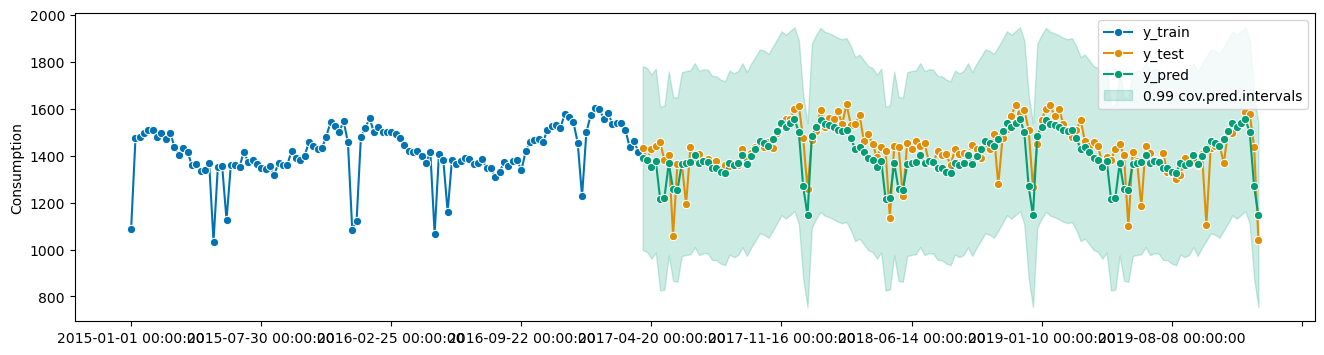

In [17]:


# also requires predictions
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])


ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["Consumption"][coverage]["lower"],
    y_pred_ints["Consumption"][coverage]["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{coverage} cov.pred.intervals",
)
ax.legend();


Отметим, что отдельные квантили могут быть расчитаны, если покрытие задано списком.

In [18]:
coverage = [0.5, 0.9, 0.95]
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints.head(3)

Consumption                                                      \
                   0.50                      0.90                      0.95   
                  lower        upper        lower        upper        lower   
2017-04-06  1287.115641  1492.401359  1139.447092  1640.069908  1091.494061   
2017-04-13  1279.027141  1484.312859  1131.358592  1631.981408  1083.405561   
2017-04-20  1250.343641  1455.629359  1102.675092  1603.297908  1054.722061   

                         
                         
                  upper  
2017-04-06  1688.022939  
2017-04-13  1679.934439  
2017-04-20  1651.250939

также посмотрим на квантили сходимости по заданым квантиляем

In [19]:
alpha = [0.1, 0.5,  0.9]
y_pred_quantiles = forecaster.predict_quantiles(alpha=alpha)
y_pred_quantiles.head(3)

Consumption                        
                    0.1        0.5          0.9
2017-04-06  1194.733866  1389.7585  1584.783134
2017-04-13  1186.645366  1381.6700  1576.694634
2017-04-20  1157.961866  1352.9865  1548.011134

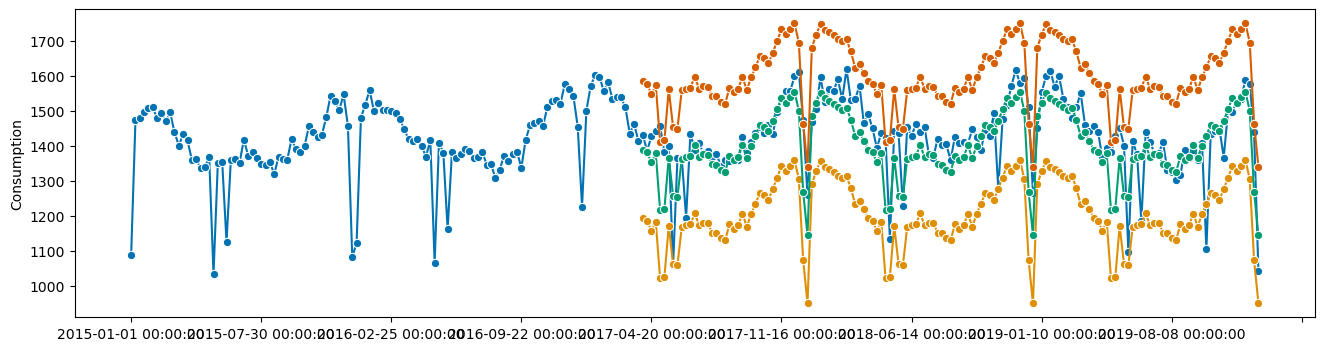

In [20]:
_, columns = zip(*y_pred_quantiles.items())
fig, ax = plot_series(y, *columns)

Аналогична может быть произведена оценка дисперсии предсказаний

In [21]:
y_pred_variance = forecaster.predict_var()
y_pred_variance.head(3)

,0
2017-04-06,23158.305092
2017-04-13,23158.305092
2017-04-20,23158.305092


Построим оценку

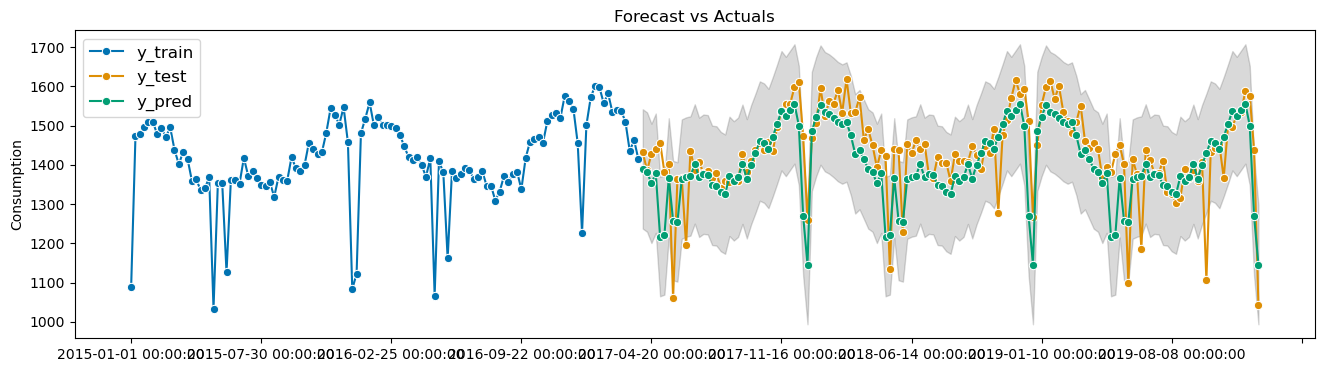

In [22]:
lower_series = pd.Series(y_pred.values.squeeze() - np.sqrt(y_pred_variance.values.squeeze()), index=y_test.index)
upper_series = pd.Series(y_pred.values.squeeze() + np.sqrt(y_pred_variance.values.squeeze()), index=y_test.index)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

ax.fill_between(ax.get_lines()[-1].get_xdata(), 
             lower_series.values, 
             upper_series.values, 
             color='k', 
             alpha=0.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()


### Мера вероятностного прогнозирования

Рассмотрим квантильный прогноз (`pred_quantiles`).
формально, квантильный прогноз $\widehat{y}_j(t_i)$, - это прогнозы для квантиля $\alpha_j$, в диапазоне $i=1\dots N, j=1\dots k$; $\alpha_j$ - элементы `alpha`, а $t_i$ - будущие метки, индексируемые в `fh`.
<!-- Let's Generating some quantile predictions.
`pred_quantiles` now contains quantile forecasts\
formally, forecasts $\widehat{y}_j(t_i)$ where $\widehat{y_j}$ are forecasts at quantile $\alpha_j$, with range $i=1\dots N, j=1\dots k$\
$\alpha_j$ are the elements of `alpha`, and $t_i$ are the future time stamps indexed by `fh` -->

In [23]:
forecaster.fit(y_train, fh=fh)
pred_quantiles = forecaster.predict_quantiles(alpha=[0.1, 0.25, 0.5, 0.75, 0.9])
pred_quantiles.head(2)

Consumption                                                  
                   0.10         0.25       0.50         0.75         0.90
2017-04-06  1194.733866  1287.115641  1389.7585  1492.401359  1584.783134
2017-04-13  1186.645366  1279.027141  1381.6700  1484.312859  1576.694634

При оценках указанного выше рода возникает вопрос о том, как использовать значения (например квантилей) для сравнения моделей предсказания между собой (соотвественно и как выбрать [оценку для настройки методов предсказания](https://arxiv.org/pdf/2211.02989.pdf)). 

Часто в такхи случаях используют дополнительную меру -  [квантильную функцию потерь](https://github.com/aryan-jadon/Regression-Loss-Functions-in-Time-Series-Forecasting-PyTorch) ([quantiles loss](https://www.lokad.com/quantile-regression-time-series-definition/) интервальные потери, `pinball loss`, в одномерном случае).

Для значения квантиля $\alpha$ функция потерь [<tt>pinball loss</tt>](https://www.lokad.com/pinball-loss-function-definition/)  определяется как\
$$L_{\alpha}(\widehat{y}, y) := \alpha \cdot \Theta (y - \widehat{y}) + (1-\alpha) \cdot \Theta (\widehat{y} - y)$$\
где $\Theta (x) := \begin{cases}1 \text{ if } x\ge 0 \\ 0 \text{ otherwise }\end{cases}$ - функция Хевисайда.
        
<img src='https://www.lokad.com/images/learn/pinball-loss-function_hu81c2c3c545005bb8c09de16f2dc8a888_9302_499x246_resize_q75_h2_box_3.webp' style="width:300px;">   

>Заметим, что оценка точности квантильного прогноза - сложная задача. Действительно, в отличие от классических прогнозов, где цель состоит в том, чтобы прогноз был как можно ближе к наблюдаемым значениям, в квантильных прогнозах ситуация смещена (намеренно). Поэтому наивное сравнение наблюдаемых и прогнозируемых значений не приносит эффекта. В тоже время функция потерь `pinball loss` возвращает значение, которое можно интерпретировать как [точность квантильной модели прогнозирования](https://www.lokad.com/pinball-loss-function-definition/).

>Функция `pinball loss` всегда положительна, и чем дальше от цели тем больше ее значение. Наклон функции  используется как параметр для отражения желаемого дисбаланса в квантильном прогнозе.Наиболее важный результат, связанный с функцией потерь пинбол, заключается в том, что чем меньше потери пинбола, тем точнее квантильный прогноз. В ряде случаев можно считать, что функция потерь является индекаторм отсуствия переобучения у модели. Кроме того функция может быть использовна непосредственно как метрика, позволяя сравнить несколько [моделей между собой](https://www.lokad.com/tv/2022/1/5/no1-at-the-sku-level-in-the-m5-forecasting-competition/).
<!-- https://www.lokad.com/pinball-loss-function-definition/ -->

> Отметим, что функция `pinball loss` не единственная метрика для сравнения [вероятностных прогнозов моделей](https://www.lokad.com/continuous-ranked-probability-score/), есть и лругие популярные решния, например [ранговый вероятностный скор (CSRP)](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.performance_metrics.forecasting.probabilistic.CRPS.html)
<!-- The function is always positive and the further away from the target 
, the larger the value of 
. The slope is used to reflect the desired imbalance in the quantile forecast.
The most important result associated with the pinball loss function is that the lower the pinball loss, the more accurate the quantile forecast. -->

<!-- Evaluating the accuracy of a quantile forecast is a subtle problem. Indeed, contrary to the classic forecasts where the goal is to have the forecast as close as possible from the observed values, the situation is biased (on purpose) when it comes to quantile forecasts. Hence the naive comparison observed vs forecasts is not satisfying. The pinball loss function returns a value that can be interpreted as the accuracy of a quantile forecasting model.https://www.lokad.com/pinball-loss-function-definition/ -->

<!-- It can be seen that pinball loss differs depending on the evaluated quantile. The higher the quantile, the more the loss function penalizes underestimates, and the less it penalizes overestimates. As with MSE and MAE, the goal is to minimize its values (the lower loss, the better).

Two disadvantages of quantile regression, compared to the bootstrap approach to prediction intervals, are that each quantile needs its regressor and quantile regression is not available for all types of regression models. However, once the models are trained, the inference is much faster since no iterative process is needed.

This type of prediction intervals can be easily estimated using ForecasterAutoregDirect models. -->

Возможны следцующие модификации [`pinball loss`](https://www.sktime.net/en/latest/examples/01b_forecasting_proba.html#metrics:-general-signature-and-averaging):

* *множественный квантильный прогноз* $\widehat{\bf y}:=\widehat{y}_1, \dots, \widehat{y}_k$ для квантилей ${\bf \alpha} = \alpha_1,\dots, \alpha_k$ 
$$L_{{\bf \alpha}}(\widehat{\bf y}, y) := \frac{1}{k}\sum_{i=1}^k L_{\alpha_i}(\widehat{y}_i, y)$$
* *интервальныq прогноз* $[\widehat{a}, \widehat{b}]$ при симметричной сходимости $c$   
$$L_c([\widehat{a},\widehat{b}], y) := \frac{1}{2} L_{\alpha_{low}}(\widehat{a}, y) + \frac{1}{2}L_{\alpha_{high}}(\widehat{b}, y)$$ где $\alpha_{low} = \frac{1-c}{2}, \alpha_{high} = \frac{1+c}{2}$.

При усредненнии значений функции потерь допустимы следующие варианты:
* значения квантилей, если их несколько - элементы `alpha` в `predict_interval(fh, alpha)`
* временные метки в горизонте прогнозирования `fh` - элементы `fh` в `fit(fh)`  `predict_interval(fh, alpha)`
* переменные `y`, в случае многомерного прогноз (сейчас мы рассмотриваем одномерный случай).

<!-- Сначала мы покажем значения квантилей и временные метки:
1. усреднение только по временным меткам `fh` -> одно число на значение квантиля в `alpha`
2. усреднение по ничему -> одно число на значение квантиля в `alpha` и временной метке `fh`
3. усреднение и по `fh`, и по квантильным значениям в `alpha` -> одно число
 -->

<!-- Let view the example of the quantile loss aka interval loss aka pinball loss, in the univariate case.

For one quantile value $\alpha$, the (per-sample) pinball loss function is defined as\
$L_{\alpha}(\widehat{y}, y) := \alpha \cdot \Theta (y - \widehat{y}) + (1-\alpha) \cdot \Theta (\widehat{y} - y)$,\
where $\Theta (x) := [1$ if $x\ge 0$ and $0$ otherwise $]$ is the Heaviside function.

This can be used to evaluate:

* *multiple quantile* forecasts $\widehat{\bf y}:=\widehat{y}_1, \dots, \widehat{y}_k$ for quantiles ${\bf \alpha} = \alpha_1,\dots, \alpha_k$ via\
$L_{{\bf \alpha}}(\widehat{\bf y}, y) := \frac{1}{k}\sum_{i=1}^k L_{\alpha_i}(\widehat{y}_i, y)$
* *interval forecasts* $[\widehat{a}, \widehat{b}]$ at symmetric coverage $c$ via\
$L_c([\widehat{a},\widehat{b}], y) := \frac{1}{2} L_{\alpha_{low}}(\widehat{a}, y) + \frac{1}{2}L_{\alpha_{high}}(\widehat{b}, y)$ where $\alpha_{low} = \frac{1-c}{2}, \alpha_{high} = \frac{1+c}{2}$

(all are known to be strictly proper losses for their respective prediction object)

There are *three things we can choose to average over*:

* quantile values, if multiple are predicted - elements of `alpha` in `predict_interval(fh, alpha)`
* time stamps in the forecasting horizon `fh` - elements of `fh` in `fit(fh)` resp `predict_interval(fh, alpha)`
* variables in `y`, in case of multivariate (later, first we look at univariate)

We will show quantile values and time stamps first:

1. averaging by `fh` time stamps only -> one number per quantile value in `alpha`

2. averaging over nothing -> one number per quantile value in `alpha` and `fh` time stamp

3. averaging over both `fh` and quantile values in `alpha` -> one number
 -->

In [24]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

вычислим  среднее значение функции потерь для заданного горизонта прогназирования

In [25]:
forecaster.fit(y_train, fh=fh)
pred_quantiles = forecaster.predict_quantiles(alpha=[0.1, 0.25, 0.5, 0.75, 0.9])

loss = PinballLoss(score_average=False)
loss(y_true=y_test, y_pred=pred_quantiles)

0.10    23.330441
0.25    37.254759
0.50    29.350073
0.75    25.368151
0.90    17.463329
Name: 0, dtype: float64

Вычислим индивидуальные значения потерь, по выборке, без усреднения,
т.е. $L_{\alpha}(\widehat{y}(t_i), y(t_i))$ для каждого $t_i$ в `fh` и каждого $\alpha$ в `alpha`
<!-- это одно число для каждого значения квантиля $\alpha$ в `alpha` и временной точки $t_i$ в `fh`. -->
<!-- 2. computing the the individual loss values, by sample, no averaging,\
i.e., $L_{\alpha}(\widehat{y}(t_i), y(t_i))$ for every $t_i$ in `fh` and every $\alpha$ in `alpha`\
this is one number per quantile value $\alpha$ in `alpha` and time point $t_i$ in `fh` -->

In [26]:
loss_pb = loss.evaluate_by_index(y_true=y_test, y_pred=pred_quantiles)
loss_pb.head(3)

,0.10,0.25,0.50,0.75,0.90
0,23.691713,36.133840,20.94625,15.187590,15.313213
1,19.944963,26.766965,2.21250,24.554465,19.059963
2,26.934313,44.240340,37.15925,7.081090,12.070613


Наконец вычислим значение функции потерь  для всех значений `alpha` и `fh`

In [27]:
loss_multi = PinballLoss(score_average=True)
val = loss_multi(y_true=y_test, y_pred=pred_quantiles)
print(val)


26.55335082032413


посмотрим на функцию потерь по шагам горизонта (каждое значение - это усреднение по квантилям)

In [28]:
loss_multi.evaluate_by_index(y_true=y_test, y_pred=pred_quantiles).head(3)

0    22.254521
1    18.507771
2    25.497121
dtype: float64

Аналогично изученному случаю с квантилям можно расчитать функцию потерь и для других типов вероятносного прогнозирования. Ниже пример интервального прогноза.  

In [29]:
pred_interval = forecaster.predict_interval(coverage=0.8)
loss(y_true=y_test, y_pred=pred_interval)


0.1    23.330441
0.9    17.463329
Name: 0, dtype: float64

### Использование вероятностного прогназирование в процедуре `backtest`

Изученная функция потерь может быть использована в режиме тестирования моделей, [например на ретроданных](https://www.sktime.net/en/latest/examples/01b_forecasting_proba.html#evaluation-by-backtesting). Для этого в функции `evaluate` нужно указывать заданный `pinball loss` как параметр  `scoring`. Отметим, что в результатах каждая строка - это один сплит тренировки/теста в режиме `walk forward` для заданной `cv` функции.

In [30]:
loss = PinballLoss()
 
fh=1+np.arange(52)
cv = ExpandingWindowSplitter(step_length=20, fh=fh,  initial_window = len(y_train) )

forecaster =  NaiveForecaster(sp=52)

results = evaluate(
    forecaster=forecaster, y=y.values, cv=cv, strategy="refit", return_data=True, scoring=loss
)


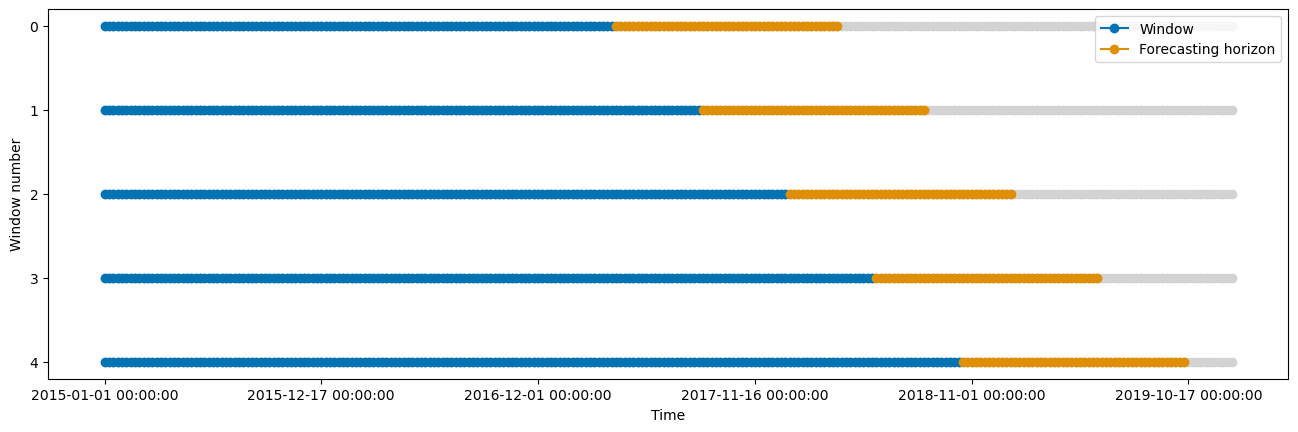

,test_PinballLoss,fit_time,pred_quantiles_time,len_train_window,cutoff
0,10.236502,0.002559,0.105907,118,117
1,11.588393,0.003000,0.111938,138,137
2,11.429554,0.004337,0.091560,158,157
3,9.791449,0.006179,0.104094,178,177
4,11.426408,0.003738,0.099436,198,197


In [31]:
plot_windows(cv, y,); plt.show()
results.iloc[:, :5]

In [32]:
# Также фреймворк `sktime` позволяет построить калибровочную кривую предсказаний. Такая кривая позволяет оценить смещение результатов прогноза относительно квантиля $0.5$.
# from sktime.utils.plotting import plot_calibration
# plot_calibration(y_true=y_test.loc[pred_quantiles.index], y_pred=pred_quantiles);

## Шаблоны создания моделей предсказания

Библиотека `sktime` поддерживает ряд продвинутых шаблонов композиции для создания моделей прогноза из нескольких компонентов. [Такими методами могут быть следующие](https://www.sktime.net/en/latest/examples/01_forecasting.html#3.-Advanced-composition-patterns---pipelines,-reduction,-autoML,-and-more).

* [__Редукция__](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.compose.make_reduction.html)  - построение прогноза из оценок более "простых" фреймровков работы с моделями машинного обучения, таких как регрессоры scikit-learn. Приемами редукции являются табуляция с помощью скользящего окна - так называемая "стратегия прямой редукции".
* [__Тюнинг моделей__](https://machinelearningmastery.com/how-to-grid-search-deep-learning-models-for-time-series-forecasting/) - определение значений гиперпараметров модели прогноза на основе данных. Частым примером является `GridSearch` поиск на временно скользящем оконе разделения на тренировку/тестирование.
* [__Конвейеризация__](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.compose.TransformedTargetForecaster.html) - объединение нескольких техник, например предобработки с моделью прогноза для получения единого предсказателя. Частым примером предобработки является удаление тренда (`detrender`)  и сезона `deseasonalizer` с последующим прогнозированием. Может быть произведено разложение временного ряда, например "STL forecaster".
* [__AutoML__](https://winedarksea.github.io/AutoTS/build/html/source/tutorial.html), также известный как автоматизированный выбор модели - использование автоматизированных стратегий настройки для выбора не только гиперпараметров, но и подходов прогнозирования. Распространенным примером является выбор методов в режиме реального времени.
* [__Ансамблирование моделей__](https://github.com/business-science/modeltime.ensemble) - набор методо для объеденения результатов нескольких методов.



<!-- Для наглядности все приведенные ниже оценщики будут представлены в рамках базового рабочего процесса прогнозирования, хотя они также поддерживают расширенные рабочие процессы прогнозирования и оценки в рамках единого интерфейса aeon (см. раздел 1).

Для использования в других рабочих процессах просто замените "блок спецификации форкастера" ("forecaster=") на блок спецификации форкастера в примерах, представленных ниже. -->


<!-- aeon supports a number of advanced composition patterns to create forecasters out of simpler components:
* Reduction - building a forecaster from estimators of “simpler” scientific types, like scikit-learn regressors. A common example is feature/label tabulation by rolling window, aka the “direct reduction strategy”.
* Tuning - determining values for hyper-parameters of a forecaster in a data-driven manner. A common example is grid search on temporally rolling re-sampling of train/test splits.
* Pipelining - concatenating transformers with a forecaster to obtain one forecaster. A common example is detrending and deseasonalizing then forecasting, an instance of this is the common “STL forecaster”.
* AutoML, also known as automated model selection - using automated tuning strategies to select not only hyper-parameters but entire forecasting strategies. A common example is on-line multiplexer tuning. -->

### Редукция временного ряда

Начнем с пункта <b>Редукция временного ряда</b>. Редукция предоставляет собой мета-метод, который позволяет использовать любой оценочный инструмент, например `scikit-learn` или совместимых фреймворков для прогнозирования. Как правило в таких фреймворках требуется табличная модальность данных. В случае временного ряда это может означать что каждый семпл теперь будет считаться значением столбца таблицы.

Посмотрим на на работу редукции на примере стратегии <b><code>recursive reduction </code></b>. Принцип работы показана ниже.  Принцип заключается в движении по меткам ряда окна, размером с тренировочную выборку, таким образом, что каждый следующий семпл ответ связан с положением окна. Данная техника может быть реализована в рамках  функции `make_reduction`. Отметим, что в общем случае [данная функция имеет и другие режимы редукции](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.compose.make_reduction.html) можно найти в спраке. Другими режимами могут быть `direct`, и `multioutput`. 

<img src="https://www.cienciadedatos.net/images/transform_timeseries.gif" width = 500px>

В примере мы определим стратегию редукции к сформированной таблице для  регрессора `k-nearest neighbors` (`sklearn KNeighborsRegressor`). Режим редукции - рекурсивный. 

> Отметим, что на самом деле есть некоторые [различия](https://www.sktime.net/en/latest/examples/01a_forecasting_sklearn.html) между задачами регрессии (типичными для пакета `sklearn`) и задачами предсказания временных рядов. \
> Также отметим отдельную возможность решения задач регрессии в рамках пакетов для предсказания [временных рядов](https://www.aeon-toolkit.org/en/latest/examples/regression/regression.html).
> Дополнительно стоит указать на формальную возможносать решения задач [регрессии ВР](https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost) без использования [сторонних библиотек](https://machinelearningmastery.com/random-forest-for-time-series-forecasting/).


<!-- aeon provides a meta-estimator that allows the use of any scikit-learn estimator for forecasting.

modular and compatible with scikit-learn, so that we can easily apply any scikit-learn regressor to solve our forecasting problem,

parametric and tuneable, allowing us to tune hyper-parameters such as the window length or strategy to generate forecasts

adaptive, in the sense that it adapts the scikit-learn’s estimator interface to that of a forecaster, making sure that we can tune and properly evaluate our model

Example: we will define a tabulation reduction strategy to convert a k-nearest neighbors regressor (sklearn KNeighborsRegressor) into a forecaster. The composite algorithm is an object compliant with the aeon forecaster interface (picture: big robot), and contains the regressor as a parameter accessible component (picture: little robot). In fit, the composite algorithm uses a sliding window strategy to tabulate the data, and fit the regressor to the tabulated data (picture: left half). In predict, the composite algorithm presents the regressor with the last observed window to obtain predictions (picture: right half). -->

In [33]:
from sklearn.utils._testing import set_random_state

sMAPE = 0.059


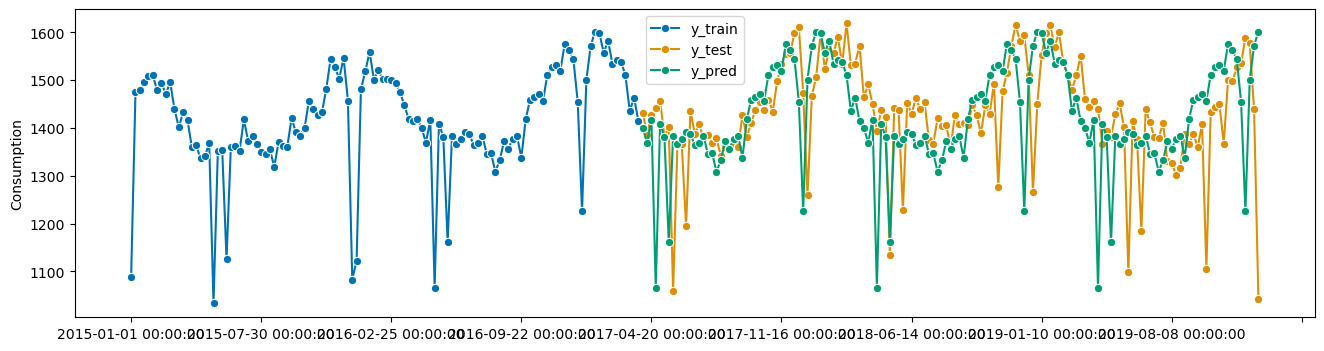

In [34]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=52, strategy="recursive")

fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Отметим, что экзогенные факторы и мультимодальные (многокомпонентные) ряды могут также быть сведены к табличному виду.

[Экзогенные факторы](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html#Machine-learning-for-forecasting) могут быть добавлены [в виде дополнительного столбца данных](https://joaquinamatrodrigo.github.io/skforecast/0.4.3/notebooks/autoregresive-forecaster-exogenous.html).
<img src="https://skforecast.org/0.5.0/img/matrix_transformation_with_exog_variable.png" width = 500px>

Отметим также, что многокомпонентные ряды также могут быть представлены [в виде нескольких таблиц](https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/dependent-multi-series-multivariate-forecasting.html).
<!-- <img src="https://skforecast.org/0.5.0/img/forecaster_multivariate_train_matrix_diagram.png" width = 500px> -->


Старатегии рекурсси могут быть разилчиными, например: [`direct`, `recursive` или `multioutput`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.compose.make_reduction.html).

sMAPE = 0.039


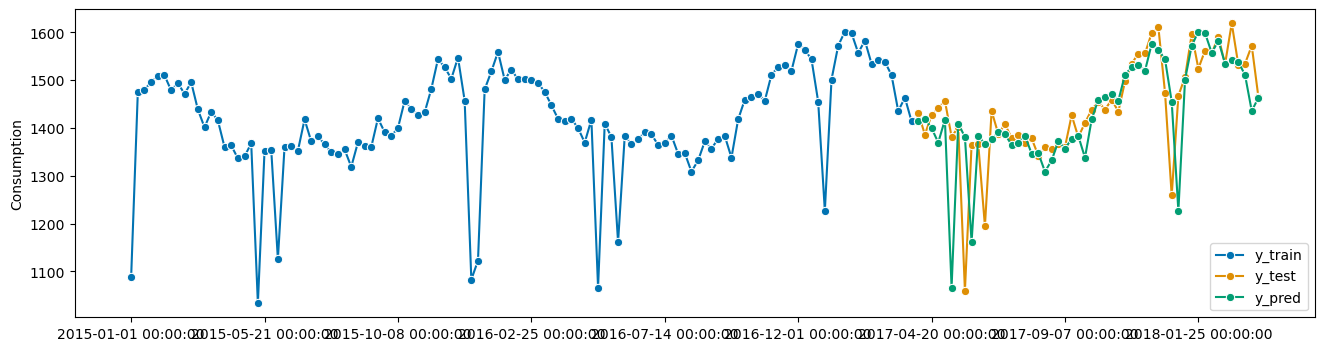

In [35]:
# from sklearn.ensemble import HistGradientBoostingRegressor
regressor  = KNeighborsRegressor(n_neighbors=1) #HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=52)
# fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster.fit(y_train.values, fh =np.arange(52)+1)
y_pred = forecaster.predict()

y_pred = pd.Series(y_pred.squeeze())
y_pred.index = y_test.index[:52]

plot_series(y_train, y_test[:52], y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values[:52]):.3f}')

В  следующих двух разделах будет также показано как можно встроить пайплайны с использованием редукции временных рядов в продвинутые модели предсказания. Также отметим что существуют и более развернутые фреймворки [адаптации табличных фреймворков к задачам временных рядов](https://cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html). Кроме того некоторый функционал по предсказанию временных рядов можно найти и [в стандартных табличных фреймворках](https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html).

### Построение конвейера предсказаний

Рассмотрим возможность создания <b>конвейеров (`pipeline`)</b> как единых моделей предсказания. Библиотека `sktime` предоставляет особый  тип конвейера для  моделей предсказания  `TransforemdTargetForecaster`. Однако, это не единственный тип конвейеров [в фреймоврке](https://github.com/sktime/sktime/blob/main/examples/03_transformers.ipynb). Конвейер связывает произвольное количество преобразований([transforms](https://www.aeon-toolkit.org/en/stable/examples/transformations/transformations.html#Pipelines-with-transformers)) или других вспомогательных операций с моделью прогноза. Преобразования могут быть как предобработкой, так и постобработкой результатов прогноза временного ряда. Пример конвейера с моделью и предварительными преобразованиями можно увидеть ниже. 

<!-- aeon provides a generic pipeline object for this kind of composite modelling, the TransforemdTargetForecaster. It chains an arbitrary number of transformations with a forecaster. The transformations can either be pre-processing transformations or a post-processing transformations. An example of a forecaster with pre-processing transformations can be seen below -->

In [21]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

sMAPE = 0.043


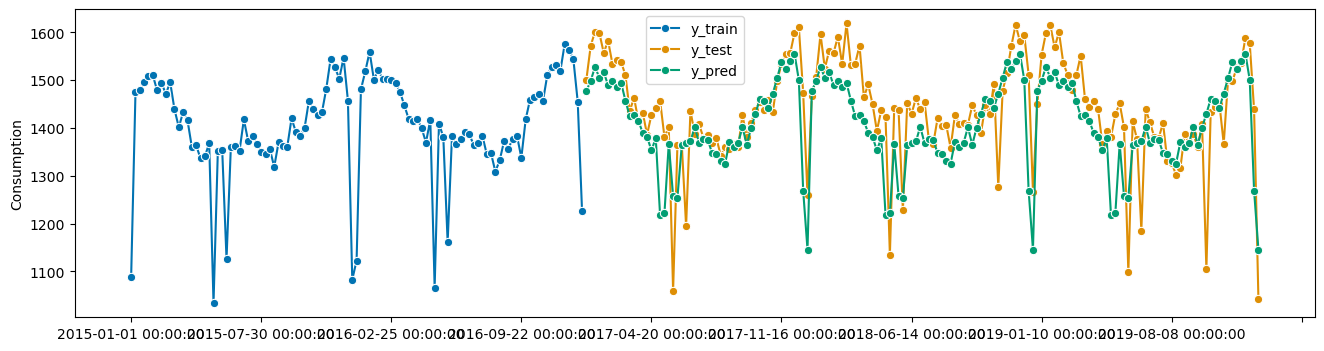

In [22]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=0))),
        ("forecast", NaiveForecaster(strategy='mean',sp=52)),
    ]
)

fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Для того, чтобы более верно понять [суть конвейера](https://github.com/sktime/sktime/blob/main/examples/03b_forecasting_transformers_pipelines_tuning.ipynb) создадим ешл аналог без использования объекта `TransformedTargetForecaster`.

In [23]:
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

detrender = Detrender(forecaster=PolynomialTrendForecaster(degree=0))
deseasonalizer = Deseasonalizer(model="multiplicative", sp=52)
forecaster = NaiveForecaster(strategy='mean',sp=52)

# fit_transform
y_train_1 = deseasonalizer.fit_transform(y_train)
y_train_2 = detrender.fit_transform(y_train_1)

# fit
forecaster.fit(y_train_2)

# predidct
y_pred_2 = forecaster.predict(fh)

# inverse_transform
y_pred_1 = detrender.inverse_transform(y_pred_2)
y_pred = deseasonalizer.inverse_transform(y_pred_1)

В данном примере видно наличие двух операций, заменяемых одной в составе конвейера: прямое преобразование (выполняемое в качестве предобработки) и обратное преобразование (постобработке).  Кроме того сама структура преобразования кажется куда менее читаемой, чем при использовании конвейера. 

Ниже мы проверим корректность работы ручного аналога

sMAPE = 0.043


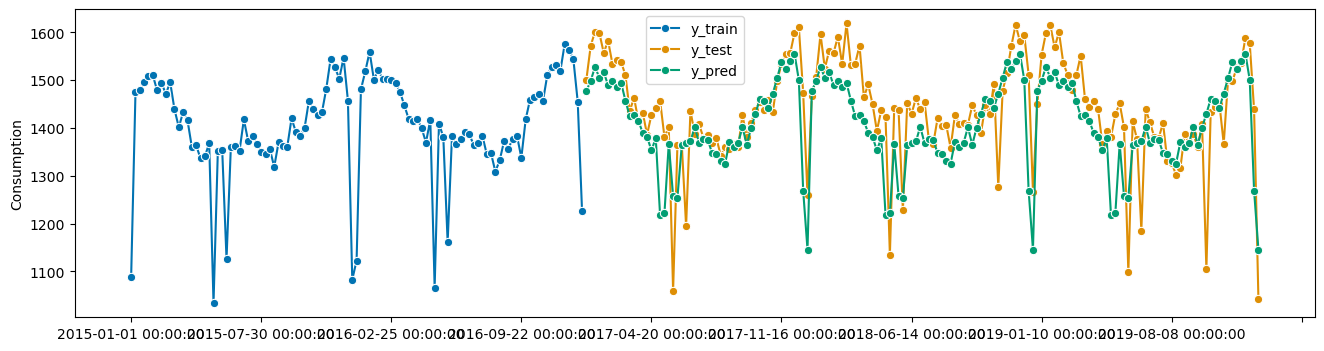

In [24]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

На самом деле реализация конвейера может быть минималистична записана [через оператор`*`](https://github.com/sktime/sktime/blob/main/examples/03a_transformers_cheat_sheet.ipynb). Более того  в конвейер могут быть добавлены и дополнительные операции, например при помощи класса [`FunctionTransformer`](https://www.sktime.net/en/v0.23.1/api_reference/auto_generated/sktime.transformations.series.func_transform.FunctionTransformer.html).

sMAPE = 0.043


  Покажем что это PIPELINE


TransformedTargetForecaster(steps=[Deseasonalizer(model='multiplicative',
                                                  sp=52),
                                   NaiveForecaster(sp=52, strategy='mean'),
                                   FunctionTransformer(func=<function <lambda> at 0x00000273DF8BDA80>)])

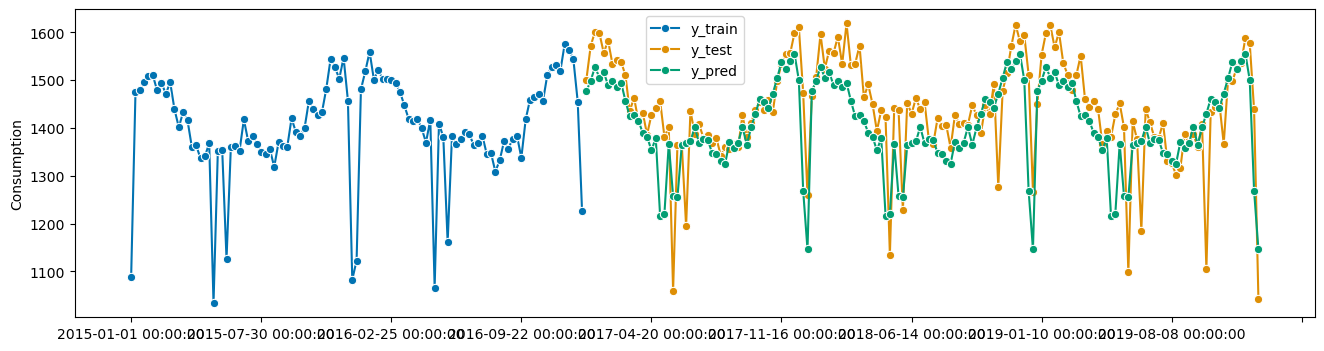

In [25]:
from sktime.transformations.series.func_transform import FunctionTransformer

forecaster = Deseasonalizer(model="multiplicative", sp=52) *\
             NaiveForecaster(strategy="mean",sp=52) *\
             FunctionTransformer(lambda y: y.round())

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

print('\n\n  Покажем что это PIPELINE')
forecaster

Так как конвейеры могут быть достаточно сложными отметим что иногда полезно показать параметры итоговой модели


In [41]:
forecaster.get_params()

{'steps': [Deseasonalizer(model='multiplicative', sp=52),
  NaiveForecaster(sp=52, strategy='mean'),
  FunctionTransformer(func=<function <lambda> at 0x000001C93062DB20>)],
 'Deseasonalizer': Deseasonalizer(model='multiplicative', sp=52),
 'NaiveForecaster': NaiveForecaster(sp=52, strategy='mean'),
 'FunctionTransformer': FunctionTransformer(func=<function <lambda> at 0x000001C93062DB20>),
 'Deseasonalizer__model': 'multiplicative',
 'Deseasonalizer__sp': 52,
 'NaiveForecaster__sp': 52,
 'NaiveForecaster__strategy': 'mean',
 'NaiveForecaster__window_length': None,
 'FunctionTransformer__X_type': None,
 'FunctionTransformer__check_inverse': True,
 'FunctionTransformer__func': <function __main__.<lambda>(y)>,
 'FunctionTransformer__inv_kw_args': None,
 'FunctionTransformer__inverse_func': None,
 'FunctionTransformer__kw_args': None}

Отдельно отеметим возможность упращения ряда алгоритмов при помощи конвейеров. Эта возможность уже упомяналась в работе `ARIMA`. Однако тут она будет полезна в смысле дискурса.

sMAPE = 0.047


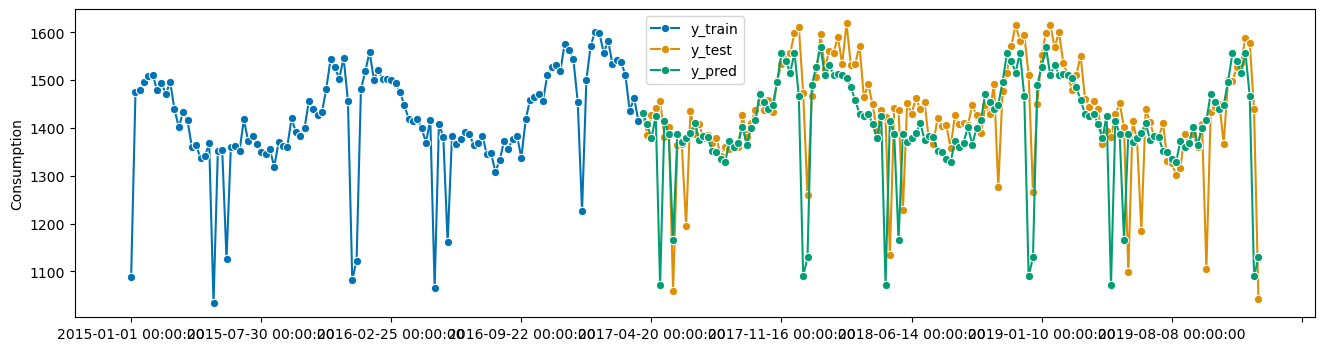

In [42]:
from sktime.forecasting.sarimax import SARIMAX
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalise", Deseasonalizer(model="multiplicative", sp=52)),
        ("forecast", SARIMAX(order=(1, 0, 0),
                             seasonal_order=(0, 0, 0, 0),),
        ),
    ]
)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Можно сравнить результат выше по сложности с тем, какой бы он был без выделения сезонности. 

Также отдельно стоит упомянуть возможность создания авторегрессионных конвейеров с использованием сторонних алгоритмов машинного обучения. Посмотрим на такой пример для градиентного бустинга.

In [43]:
import xgboost as xgb

[14:34:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

sMAPE = 0.051


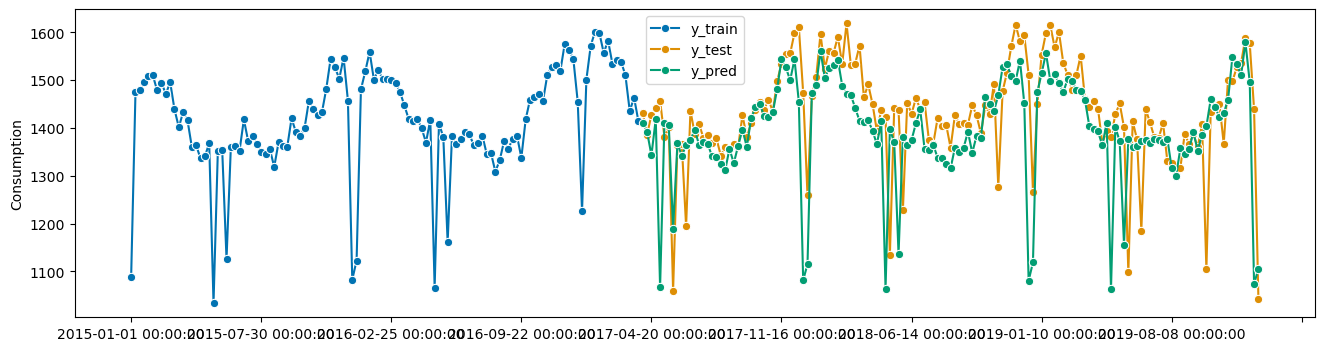

In [44]:
regressor = xgb.XGBRegressor(verbose = -1)
  
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalise", Deseasonalizer(model="multiplicative", sp=52)),
        ("forecast", make_reduction(regressor, window_length=1, strategy="recursive"),
        ),
    ]
)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Рассмотрим еще примеры полезных трюков в конвейере

sMAPE = 0.063


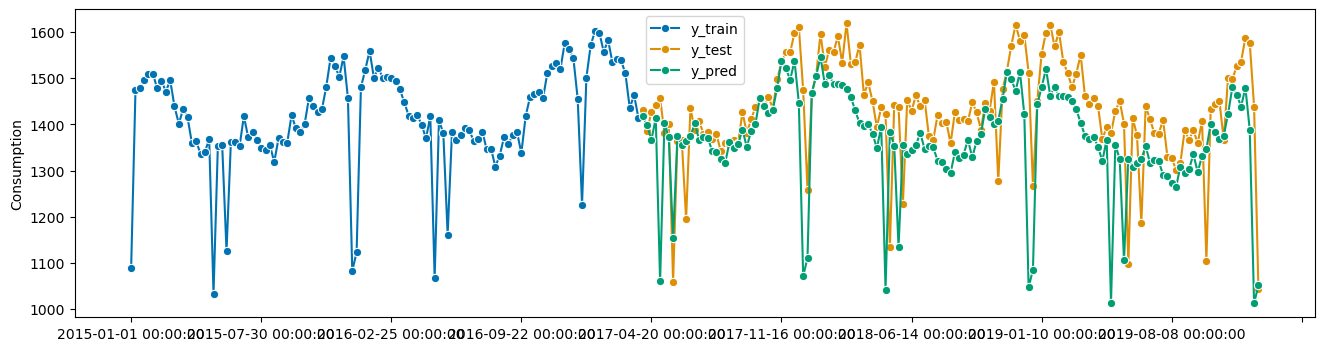

In [45]:
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer

forecaster = Differencer(lags=1) * Deseasonalizer(sp=52) * TrendForecaster()


forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
# y_pred = pd.Series(y_pred)
# y_pred.index = y_test.index
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

### Тонкая настройка моделей предсказания

Для [<b>тюинига</b>](https://github.com/sktime/sktime/blob/main/examples/03b_forecasting_transformers_pipelines_tuning.ipynb) выбранных моделей предсказания может быть использован ряд автоматизированных методов отбора параметров, например такой подходы как [`ForecastingGridSearchCV`](https://sktime-backup.readthedocs.io/en/latest/api_reference/auto_generated/sktime.forecasting.model_selection.ForecastingGridSearchCV.html). 

Подход `ForecastingGridSearchCV` (и другие тюнеры) строятся из модели для настройки методами кросс-валидации по сетке значений параметров (подобно `scikit-learn`). Также указываются и параметры, специфичные для стратегии настройки. Также для использования этого метода нужно определится со стратегией обучения. Например `SlidingWindowSplitter`. В данном примере попробуем для этой стратегии задать не равнозначными начальное окон и скользящее окон.


In [46]:
path_ts = 'de_data.csv'
df = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")
y = df.Consumption.asfreq('7d')

TEST_SIZE = int(0.55*y.size)
y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

In [47]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

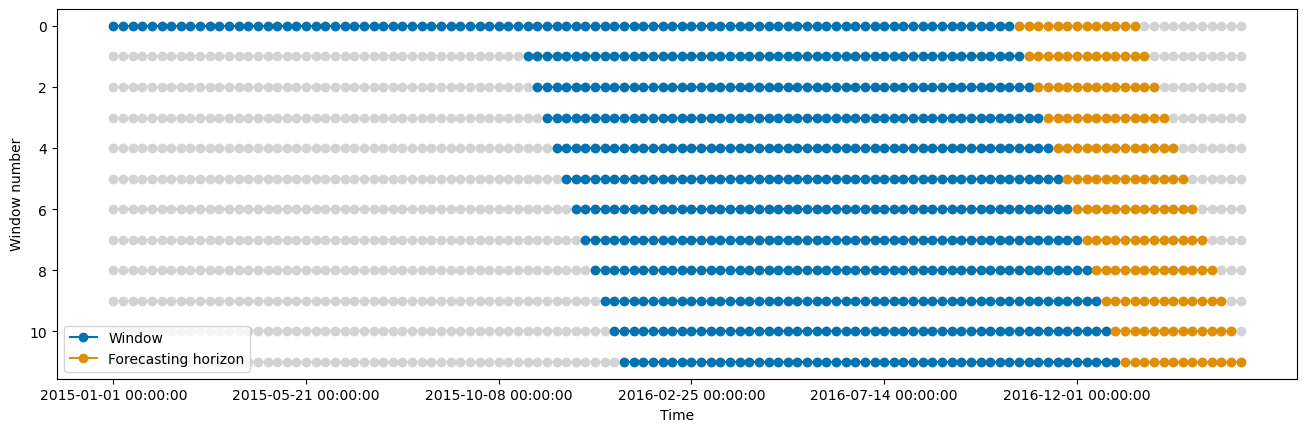

In [48]:
forecaster = NaiveForecaster(sp=52)

param_grid = {"sp": [13, 26, 52]}

cv = SlidingWindowSplitter(initial_window=int(len(y_train.values) * 0.8), window_length=52, fh=1+np.arange(13))

gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)

plot_windows(cv,y_train)

Посмотрим на выбор модели

In [49]:
gscv.fit(y_train.values)
gscv.best_params_

{'sp': 52}

Отметим то, как бы выглядило растущее окно `ExpandingWindowSplitter`.

{'sp': 52}


(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

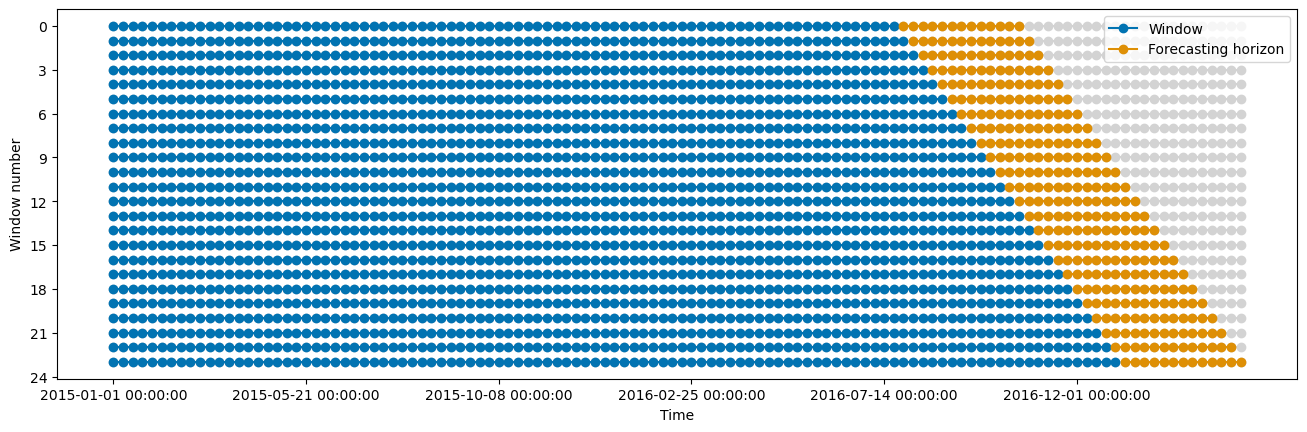

In [50]:
fh=1+np.arange(52)
cv = ExpandingWindowSplitter(initial_window=int(len(y_train.values) * 0.7), fh=np.arange(13)+1)

gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)
gscv.fit(y_train.values)
print(gscv.best_params_)

plot_windows(cv,y_train)

Все алгоритмы настройки в aeon позволяют пользователю задать скор оценки параметров(score); для прогнозирования по умолчанию используется средняя абсолютная процентная ошибка (`MeanAbsolutePercentageError`). Оценка может быть задана с помощью аргумента `score`. Зададим аргумент `MeanSquaredPercentageError`. Результат будем теперь смотреть не только как лучший из сетки поиска, но как всю сводку. Для этого используетм  метод `cv_results_`.

In [51]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanSquaredPercentageError

forecaster = NaiveForecaster(sp=52)

param_grid = {"strategy" : ["last", "mean", "drift"], "window_length":[None,52]}

cv = ExpandingWindowSplitter(initial_window=int(len(y_train.values) * 0.5), fh=np.arange(52)+1)

gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid, scoring=MeanSquaredPercentageError()
)

gscv.fit(y_train.values)
gscv.cv_results_.sort_values(by='mean_test_MeanSquaredPercentageError')

,mean_test_MeanSquaredPercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredPercentageError
0,0.006192,0.009259,0.145732,"{'strategy': 'last', 'window_length': None}",2.0
1,0.006192,0.004789,0.137628,"{'strategy': 'last', 'window_length': 52}",2.0
3,0.006192,0.003683,0.005190,"{'strategy': 'mean', 'window_length': 52}",2.0
2,0.006318,0.003788,0.005600,"{'strategy': 'mean', 'window_length': None}",4.0
5,0.009402,0.020048,0.008764,"{'strategy': 'drift', 'window_length': 52}",5.0
4,0.029827,0.014083,0.008669,"{'strategy': 'drift', 'window_length': None}",6.0


Помимо традиционных решений для метрик возможно использование и вероятностных метрик

In [52]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

forecaster = NaiveForecaster(sp=52)

param_grid = {"strategy" : ["last", "mean", "drift"], "window_length":[None,52]}

cv = ExpandingWindowSplitter(initial_window=int(len(y_train.values) * 0.5), fh=np.arange(52)+1,  step_length=20)

gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid, scoring=PinballLoss()
)

gscv.fit(y_train.values, fh=np.arange(52)+1,)


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52]),
                                                   initial_window=59,
                                                   step_length=20),
                        forecaster=NaiveForecaster(sp=52),
                        param_grid={'strategy': ['last', 'mean', 'drift'],
                                    'window_length': [None, 52]},
                        scoring=PinballLoss())

In [53]:
gscv.cv_results_.sort_values(by='mean_test_PinballLoss')

,mean_test_PinballLoss,mean_fit_time,params,rank_test_PinballLoss
2,15.524876,0.003303,"{'strategy': 'mean', 'window_length': None}",1.0
0,16.808656,0.002741,"{'strategy': 'last', 'window_length': None}",2.5
1,16.808656,0.002591,"{'strategy': 'last', 'window_length': 52}",2.5
5,20.300794,0.013362,"{'strategy': 'drift', 'window_length': 52}",4.0
4,26.399831,0.032872,"{'strategy': 'drift', 'window_length': None}",5.0
3,NaN,0.002561,"{'strategy': 'mean', 'window_length': 52}",NaN


In [54]:
gscv.predict_interval().head(3)

0             
             0.9             
           lower        upper
118  1139.447092  1640.069908
119  1131.358592  1631.981408
120  1102.675092  1603.297908

sMAPE = 0.043


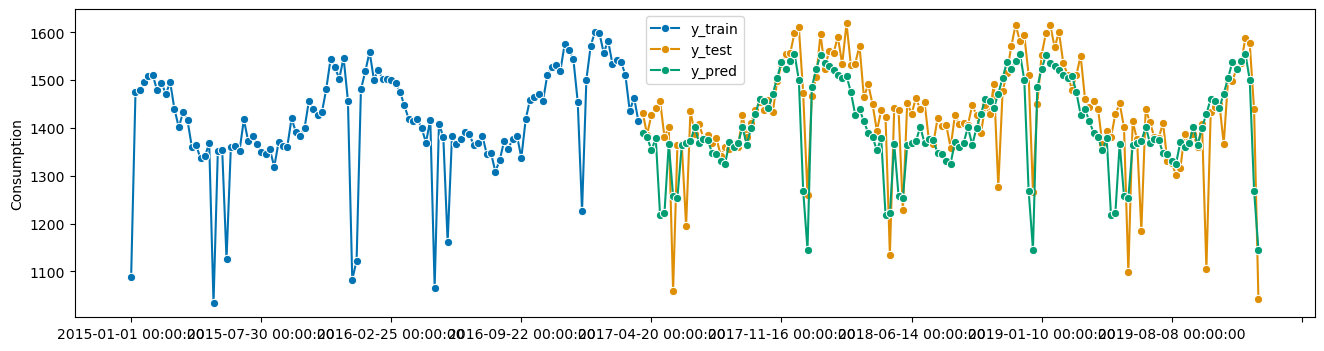

In [55]:
fh = 1+np.arange(len(y_test))
y_pred = gscv.predict(fh).squeeze()
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Отметим что часто настройка необходима не только для отдельных предсказтелей, но и для [конвейеров предказания](https://github.com/sktime/sktime-tutorial-ODSC-Europe-2023/blob/main/notebooks/04_feateng_pipe_tune.ipynb). Эти примеры мы покажем ниже.

### Автоматизация обучения предсказателей

Помимо тюнинга, может быть проведен и автоматический выбор моделей (**AutoML**). Напомним, что Тюнинг  использует стратегии, основанные на данных, для поиска оптимальных гиперпараметров для выбранной модели. Авто выбор модели объединяют выбор на уровне [моделей](https://michael-fuchs-python.netlify.app/2022/03/01/automl-for-time-series-analysis/), или их комбинаций. При этом могут также быть настроены параметры моделей или их ансамблирования.

<!-- aeon provides a number of compositors for ensembling and automated model selection. In contrast to tuning, which uses data-driven strategies to find optimal hyper-parameters for a fixed forecaster, the strategies in this section combine or select on the level of estimators, using a collection of forecasters to combine or select from.

The strategies discussed in this section are: * autoML aka automated model selection * simple ensembling * prediction weighted ensembles with weight updates, and hedging strategies -->

Наиболее гибким способом отбора моделей по прогнозистам является использование [`MultiplexForecaster`](https://github.com/sktime/sktime/discussions/5122), который представляет выбор модели из списка как гиперпараметр, настраиваемый с помощью типичных стратегий настройки гиперпараметров. У данного метода  есть единственный гиперпараметр, `selected_forecaster`. Данный метод будем использовать для тюнинга в аналогичной выше манере.

<!-- The most flexible way to perform model selection over forecasters is by using the `MultiplexForecaster`, which exposes the choice of a forecaster from a list as a hyper-parameter that is tunable by generic hyper-parameter tuning strategies
 
MultiplexForecaster is constructed with a named list forecasters, of forecasters. It has a single hyper-parameter, selected_forecaster, which can be set to the name of any forecaster in forecasters, and behaves exactly like the forecaster keyed in forecasters by selected_forecaster.

The MultiplexForecaster is not too useful in isolation, but allows for flexible autoML when combined with a tuning wrapper. -->

In [56]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.croston import Croston
from sktime.forecasting.tbats import TBATS

In [57]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("season", NaiveForecaster(strategy="last", sp=52)),
        ("ets", ExponentialSmoothing(trend="add", sp=52)),
        ("hw", ExponentialSmoothing(trend="add", seasonal='add', sp=26)),
        ("TBATS", TBATS( sp=52,
                        use_box_cox=False,
                        use_trend=False,
                        use_damped_trend=False,
                        use_arma_errors=False,
                        n_jobs=1))
        
    ],
)
forecaster.set_params(**{"selected_forecaster": "ets"})

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('season', NaiveForecaster(sp=52)),
                                 ('ets',
                                  ExponentialSmoothing(sp=52, trend='add')),
                                 ('hw',
                                  ExponentialSmoothing(seasonal='add', sp=26,
                                                       trend='add')),
                                 ('TBATS',
                                  TBATS(n_jobs=1, sp=52, use_arma_errors=False,
                                        use_box_cox=False,
                                        use_damped_trend=False,
                                        use_trend=False))],
                    selected_forecaster='ets')

In [58]:
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

cv = SlidingWindowSplitter(initial_window=104, window_length=52, step_length =26, fh=np.arange(10)+1)

forecaster_param_grid = {"selected_forecaster": ["ets", "naive", "hw", "season", "TBATS"]}

gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid, scoring=MeanSquaredPercentageError())


gscv.fit(y_train.values, )

gscv.cv_results_.sort_values(by='mean_test_MeanSquaredPercentageError')

,mean_test_MeanSquaredPercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredPercentageError
4,0.001333,1.570074,0.008759,{'selected_forecaster': 'TBATS'},1.0
3,0.001807,0.024501,0.179830,{'selected_forecaster': 'season'},2.0
2,0.004784,0.234531,0.007162,{'selected_forecaster': 'hw'},3.0
0,0.006168,0.064607,0.006606,{'selected_forecaster': 'ets'},4.0
1,0.007708,0.020540,0.015317,{'selected_forecaster': 'naive'},5.0


sMAPE = 0.043


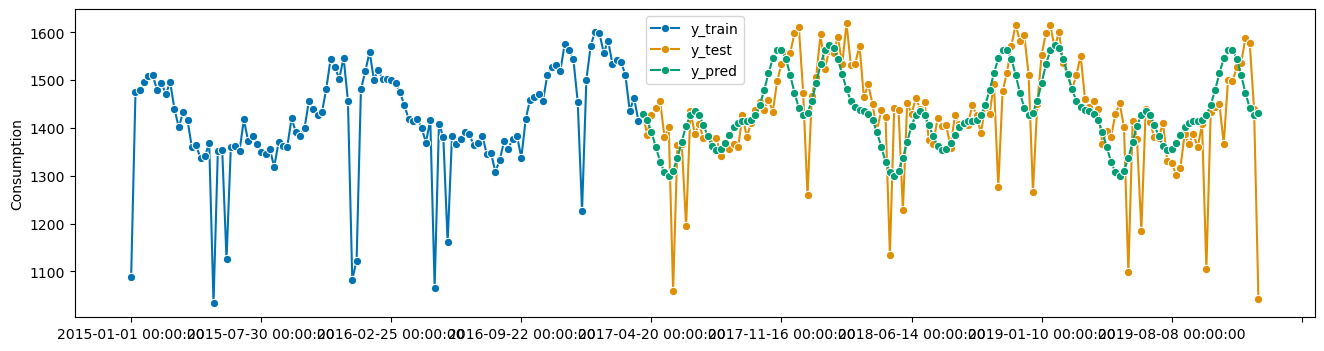

In [59]:
fh = 1+np.arange(len(y_test))#ForecastingHorizon(y_test.index, is_relative=False)
y_pred = gscv.predict(fh)

y_pred = pd.Series(y_pred.squeeze())
y_pred.index = y_test.index

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Фреймворк `sktime` также предоставляет возможности для автоматического выбора компонентов **Конвейера**, т.е. егр структуры. Это достигается с помощью преобразователя [`OptionalPassthrough`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.compose.OptionalPassthrough.html). Отметим, что у `OptionalPassthrough` есть гиперпараметр `passthrough: bool`, который можно настраивать: если выставить `False`, то он ведет себя как встроенное преобразование, если `True`, то он игнорирует преобразование. Также чтобы эффективно использовать `OptionalPasstrhough`, определите подходящий набор параметров с помощью нотации `__` (двойное подчеркивание), знакомой по `scikit-learn`. Это позволяет получать доступ и настраивать атрибуты вложенных объектов. Мы можем использовать `__` несколько раз, если у нас более двух уровней вложенности.

В следующем примере мы берем конвейер `deseasonalize/scale` и настраиваем его по четырем возможным комбинациям.


<!-- aeon also provides capabilities for automated selection of pipeline components inside a pipeline, i.e., pipeline structure. This is achieved with the OptionalPassthrough transformer.

The OptionalPassthrough transformer allows to tune whether a transformer inside a pipeline is applied to the data or not. For example, if we want to tune whether sklearn.StandardScaler is bringing an advantage to the forecast or not, we wrap it in OptionalPassthrough. Internally, OptionalPassthrough has a hyperparameter passthrough: bool that is tuneable; when False the composite behaves like the wrapped transformer, when True, it ignores the transformer within.

To make effective use of OptionalPasstrhough, define a suitable parameter set using the __ (double underscore) notation familiar from scikit-learn. This allows to access and tune attributes of nested objects like TabularToSeriesAdaptor(StandardScaler()). We can use __ multiple times if we have more than two levels of nesting.

In the following example, we take a deseasonalize/scale pipeline and tune over the four possible combinations of deseasonalizer and scaler being included in the pipeline yes/no (2 times 2 = 4); as well as over the forecaster’s and the scaler’s parameters.

Note: this could be arbitrarily combined with MultiplexForecaster, as in Section 3.4.1, to select over pipeline architecture as well as over pipeline structure.

Note: scikit-learn and aeon do not support conditional parameter sets at current (unlike, e.g., the mlr3 package). This means that the grid search will optimize over the scaler’s parameters even when it is skipped. Designing/implementing this capability would be an interesting area for contributions or research. -->

In [60]:
from sklearn.preprocessing import StandardScaler

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.series.detrend import Deseasonalizer

warnings.simplefilter('ignore', category=UserWarning)

In [61]:
pipe = TransformedTargetForecaster(
    steps=[
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(StandardScaler()))),
        ("forecaster", NaiveForecaster(sp=52)),
    ]
)

cv = SlidingWindowSplitter(initial_window=104, window_length=52, start_with_window=True)

param_grid = {
    "deseasonalizer__passthrough": [True, False],
    "scaler__transformer__transformer__with_mean": [True, False],
    "scaler__passthrough": [True, False],
    "forecaster__strategy": ["drift", "mean", "last"],
}

gscv = ForecastingGridSearchCV(forecaster=pipe, param_grid=param_grid, cv=cv, n_jobs=-1)
gscv.fit(y_train.values)

gscv.best_params_

{'deseasonalizer__passthrough': True,
 'forecaster__strategy': 'last',
 'scaler__passthrough': True,
 'scaler__transformer__transformer__with_mean': True}

sMAPE = 0.042


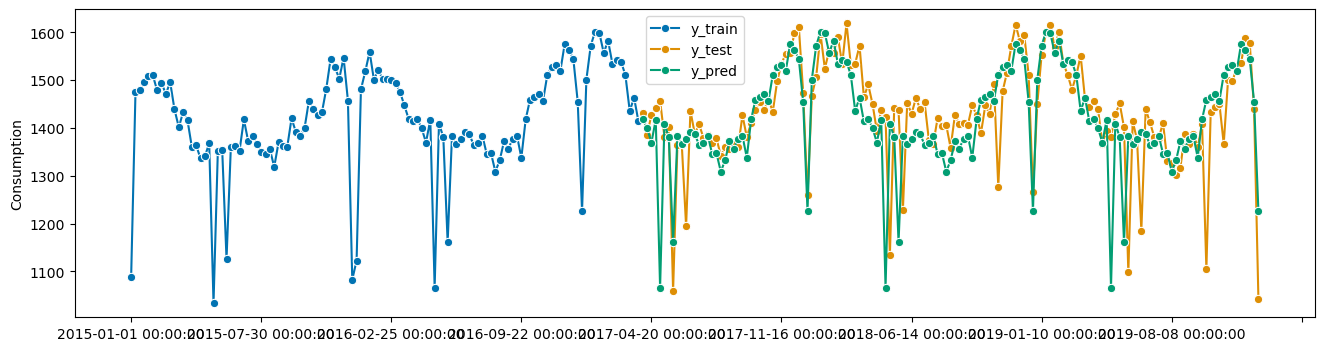

In [62]:
fh = 1+np.arange(len(y_test))#ForecastingHorizon(y_test.index, is_relative=False)
y_pred = gscv.predict(fh)

y_pred = pd.Series(y_pred.squeeze())
y_pred.index = y_test.index

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

## Ансамблирование моделей

Другим важным методом улучшения качества прогнозов является использование [методов ансамблирования предсказателей](https://petolau.github.io/Ensemble-of-trees-for-forecasting-time-series/). 
Напомним, что цель ансамблирования - объеденение нескольких моделей для уменьшения смещния предсказания каждой из них.
В частности, прогнозы каждой модели (базовые модели) складываются и используются в качестве входных данных для конечной модели (метамодели) для вычисления прогноза.
Методов ансамблирования может быть несколько, среди них такие как:
* Простой ансамбль предсказателей [`EnsembleForecaster`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.compose.EnsembleForecaster.html) - аггрегированин результатов предсказания с заданными весовыми значениями.
* Аво-Ансамблиевый предсказатель [`AutoEnsembleForecaster`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.compose.AutoEnsembleForecaster.html) - автовыбор весовых значений предсказателей.
* Стековый ансамбль предсказателей [`StackingForecaster`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.compose.StackingForecaster.html)  - стек предсказатей со сложной метомоделью.
<!-- In machine learning, stacking is an ensemble technique that combines multiple models to reduce their biases and improve predictive performance. Specifically, the predictions of each model (base models) are stacked and used as input to a final model (metamodel) to compute the prediction.https://skforecast.org/0.11.0/faq/stacking-ensemble-models-forecasting -->

In [63]:
from sktime.forecasting.compose import EnsembleForecaster

sMAPE = 0.039


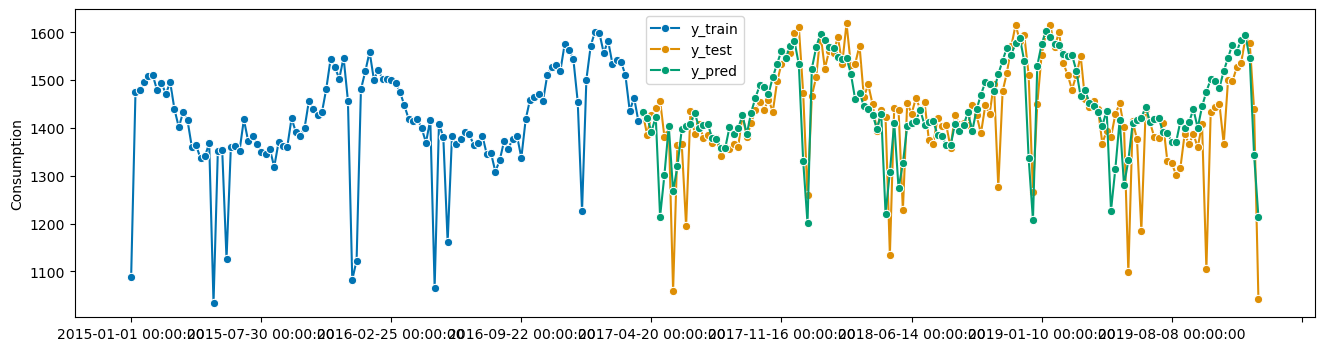

In [64]:
TBATS(sp=52, use_box_cox=False, use_trend=False,
      use_damped_trend=False, use_arma_errors=False, n_jobs=1)

hw     = ExponentialSmoothing(trend="add", seasonal='add', sp=52)

damped = ExponentialSmoothing(trend="add", seasonal='add', damped_trend=True, sp=52)

naive  = NaiveForecaster(strategy='last', window_length=52, sp=52)

forecaster = EnsembleForecaster(
    [
        ("hw", hw),
        ("damped", damped),
        ("naive", naive),
    ], weights=[4, 10, 4]
)

forecaster.fit(y_train.values)


fh = 1+np.arange(len(y_test))#ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

y_pred = pd.Series(y_pred.squeeze())
y_pred.index = y_test.index


plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Для оценки модели мы иногда хотим оценить несколько прогнозов, используя временную перекрестную валидацию со скользящим окном по тестовым данным. Для этого мы можем использовать прогнозисты из модуля `online_forecasting`, которые используют составной прогнозист, `PredictionWeightedEnsemble`, чтобы отслеживать потери, накопленные каждым прогнозистом, и создавать прогноз, взвешенный по прогнозам наиболее "точных" прогнозистов.
Обратите внимание, что задача прогнозирования изменилась: мы делаем 35 прогнозов, так как нам нужен первый прогноз для обновления весов, мы не прогнозируем на 36 шагов вперед.

Сначала нам нужно инициализировать `PredictionWeightedEnsembler`, который будет отслеживать потери, накопленные каждым прогнозистом, и определить, какую функцию потерь мы хотим использовать.

Затем мы можем создать прогнозиста, определив отдельные прогнозы и указав используемый `PredictionWeightedEnsembler`. Затем, подогнав наши прогнозисты и выполнив обновление и предсказание с помощью функции `update_predict`, мы получим:

In [65]:
from sktime.forecasting.online_learning import (
    NormalHedgeEnsemble,
    OnlineEnsembleForecaster,
)
from sktime.performance_metrics.forecasting import mean_squared_error
 
hedge_expert = NormalHedgeEnsemble(n_estimators=3, loss_func=mean_squared_error)

sMAPE = 0.104


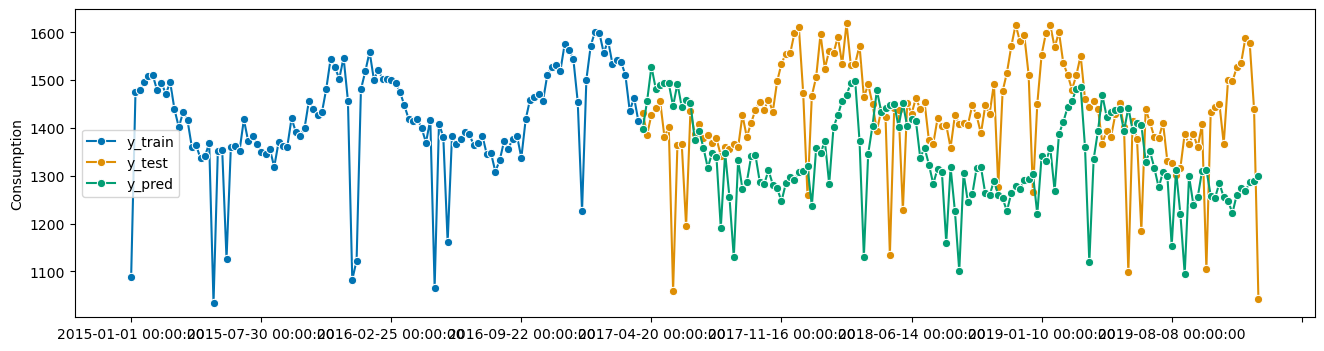

In [70]:
forecaster = OnlineEnsembleForecaster(
    [
        ("hw", hw),
        ("damped", damped),
        ("naive", naive),
    ],
    ensemble_algorithm=hedge_expert,
)

fh = 1+np.arange(len(y_test))#ForecastingHorizon(y_test.index, is_relative=False)
forecaster.fit(y=y_train.values, fh=fh)
y_pred = forecaster.update_predict_single(y_test.values)


y_pred = pd.Series(y_pred.squeeze())
y_pred.index = y_test.index

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

## _


В конце отметим некоторые «эмпирические» рекомендации к выбору предсказателей:

* всегда сначала пробуйте более простые модели
* всегда сравнивайте «простое» и «сложное»
* всегда сравнивайте собственный вариант использования, производительность тестов и ключевые показатели эффективности (например, интерпретируемость)

Отметим, что фреймворк [`sktime`](https://github.com/sktime/sktime) постоянно развивается, в том числе расширяется. Например, в последних версиях в фреймворк добавлены большое число моделей глубокого обучения нейронных сетей и других интересных современных алгоритмов. 

>Дополнительно отметим возможность встраивания [своих алгоритмов в интерфейс фреймворка](https://www.sktime.net/en/latest/examples/01_forecasting.html#4.-Extension-guide---implementing-your-own-forecaster). Для этого может быть рассмотрен в том числе [следующий шаблон](https://github.com/sktime/sktime/blob/main/extension_templates/forecasting_supersimple.py).
<!-- 
Приведем несколько примеров ранее не рассмотренных современных алгоритмов, встроенных  в фреймворк. Одними из таких являются модели предложенные в рамках знаковой статьи [*Are Transformers Effective for Time Series Forecasting?*](https://arxiv.org/pdf/2205.13504.pdf). В рамках статьи авторы предложили линейные модели, вдохнавленные эффектом "длительной памяти" в замен популярных архитектур "Трансформеров". Рассмотрим такую модель `LTSFLinearForecaster`.

from sktime.forecasting.ltsf import LTSFLinearForecaster, LTSFNLinearForecaster , LTSFDLinearForecaster

# deep learning models may have parameters set in line with fh, data, etc.
forecaster = LTSFLinearForecaster(
    seq_len=10, pred_len=10, in_channels=1, num_epochs=50, individual=True
)

fh = 1+np.arange(len(y_test))#ForecastingHorizon(y_test.index, is_relative=False)
forecaster.fit(y=y_train.values, fh=fh)
y_pred = forecaster.update_predict_single(y_test.values) 

from sktime.forecasting.neuralforecast import NeuralForecastRNN

forecaster = NeuralForecastRNN(freq = y.index.freq,  
                          context_size=10,     
                          decoder_hidden_size=200,   
                          decoder_layers=2 )


-->

<!-- Допонительно также отметим возможность построения прогнозов (скорее регрессий) временных рядов на основе [признаков  ВР](https://tsfresh.readthedocs.io/en/latest/). Такие прзинаки строятся по [лагам и стат. параметрам сегментов ВР](https://htmlpreview.github.io/?https://github.com/robjhyndman/M4metalearning/blob/master/docs/M4_methodology.html#features). Признаковыве предсказатели являются скорее экзотичными, однако позволяют сокращать пространство для хранения ВР. В этой части мы попробуем признаки библиотеки [`tsfeatures`](https://github.com/Nixtla/tsfeatures). Отметим, что указанный подход [не единственный](https://www.sktime.net/en/stable/examples/transformation/feature_extraction_with_tsfresh.html). -->